# Concious Self-Organizing Map

The concious self-organizing map of cSOM is a modified version of the Kohonen SOM which include parameters to generate a bais that prevents a single neuron from winning too much and thus generating a more faithful representation of the density distributions of the original parameter space. It works by generating a bais term that gets added to the distance calculation when determining the best matching units.

The parameters that control this will be refered to as beta and gamma. Beta controls how we deal with the winning frequency calculation as is cumulative throughout the training in the bais matrix. Gamma on the other hand is a multiplication factor that influences how much we will add to the distance calculation to deter the same neuron from winning too many times.

Values for beta should generall be 0 < ß << 1
Values for gamma are typically < 10 but I have not fully examined the limitations.

In [1]:
from sciSOM import plot_SOM_gird_neurons, calculate_u_matrix, calculate_density_matrix, display_density_matrix

In [2]:
from sciSOM import plot_SOM_gird_neurons, SOM, affine_transform
import pandas as pd
import numpy as np
import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Loading data
As with the Kohonen SOM example we will use 2 datasets. One will be a 4 clusters centered around 4 sets of 2d coordinate with gaussian noise. The second will be the penguins dataset, I data set that has been used to replace the Iris dataset. Similarly to the Iris dataset this one has 3 clusters, one of the being fully separable from the rest but not the other two.

In [3]:
# Lets make a simple dataset which we understand
# I will generate 4 data classes centered at 1,1 1,2 2,1 2,2
# Add some gaussian noise to each of those classes and see
# If the SOM was able to separate them!
n_samples = 2000  # Total number of samples
centers = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])  # Centers of the 4 Gaussian distributions
std_dev = 0.1  # Standard deviation of the Gaussian distributions
n_centers = len(centers)
samples_per_center = n_samples // n_centers

In [4]:
data = []
for center in centers:
    samples = np.random.normal(loc=center, scale=std_dev, size=(samples_per_center, 2))
    data.append(samples)

# Combine all samples into a single array
gaussian_data_4_classes = np.vstack(data)

In [5]:
gaussian_data_4_classes_norm = affine_transform(gaussian_data_4_classes, 0, 1)


### Constructing parameter tables to train the SOM
We will opt to use a decay schedule rather than the decay functions but the setup for both methods will be as bellow

In [6]:
# First we need to define datatypes as the SOM expects a numpy structured 
# array for parameters
dtype = np.dtype([
    ('time', 'i8'),  # Unicode string of max length 10
    ('alpha', 'float'),    # 4-byte integer
    ('beta', 'float'),  # 4-byte float
    ('gamma', 'float')
])

In [7]:
dtypek = np.dtype([
    ('time', 'i8'),  # Unicode string of max length 10
    ('alpha', 'float'),    # 4-byte integer
    ('sigma', 'float'),  # 4-byte float
    ('max_radius', 'i4')
])

In [8]:
parameters = np.zeros(1, dtype=dtype)
parameters_schedule = np.zeros(4, dtype=dtype)

In [9]:
ksom_parm = np.zeros(3, dtype = dtypek)

In [10]:
ksom_parm[0] = (2000, 0.3, 0.3, 3)
ksom_parm[1] = (8000, 0.1, 0.3, 2)
ksom_parm[2] = (20000, 0.05, 0.3, 1)

In [11]:
parameters[0] = (0, 0.4, 0.04, 0.3)

In [63]:
parameters_schedule = np.zeros(4, dtype=dtype)
parameters_schedule[0] = (2000, 0.5, 0.0001, 5)
parameters_schedule[1] = (8000, 0.3, 0.0008, 1) # 0.00009
parameters_schedule[2] = (20000, 0.05, 0.0008, 0.1) # 0.00008
parameters_schedule[3] = (100000, 0.005, 0.0001, 0.01) # 0.00005

In [13]:
parameters_schedule = np.zeros(3, dtype=dtypek)
parameters_schedule[0] = (2000, 0.3, 0.2, 5)
parameters_schedule[1] = (8000, 0.01, 0.1, 3)
parameters_schedule[2] = (40000, 0.001, 0.1, 1)

In [14]:
parameters_schedule

array([( 2000, 0.3  , 0.2, 5), ( 8000, 0.01 , 0.1, 3),
       (40000, 0.001, 0.1, 1)],
      dtype=[('time', '<i8'), ('alpha', '<f8'), ('sigma', '<f8'), ('max_radius', '<i4')])

In [52]:
save_schedule = np.array([0, 100, 200, 300,
                         500, 1000, 3000, 5000,
                         10000, 20000, 30_000, 40_000,
                         48_000, 49_000, 49_999])

In [64]:
# Define the SOM model, details regarding each parameter can be found in the documentation
som_model_simple = SOM(x_dim = 7, y_dim = 7, input_dim = 2, n_iter=45000,
                       learning_parameters=parameters_schedule,
                       som_type = "cSOM", #neighborhood_decay='exponential',
                       decay_type='schedule', mode = "batch", #neighborhood_decay = "none",#"geometric_series"
                       save_weight_cube_history=True,
                       csom_learning_radius = 1,
                       weight_cube_save_states = save_schedule,
                       #gamma_off=True
                      )

In [66]:
len(som_model_simple.weight_cube_save_states)

15

In [67]:
# Train the SOM model
som_model_simple.train(gaussian_data_4_classes_norm)

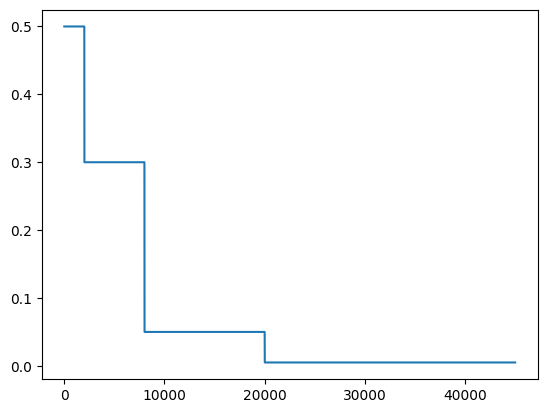

In [69]:
plt.plot(som_model_simple.learning_rate_history)

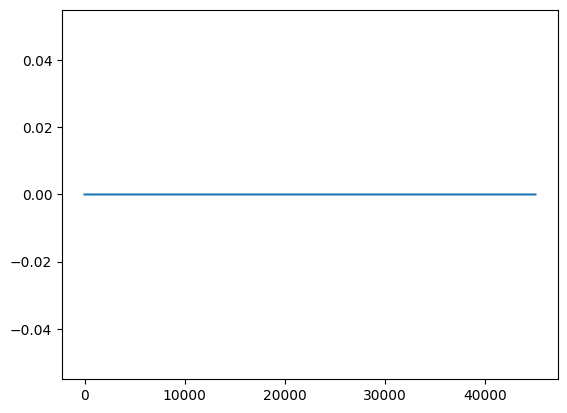

In [71]:
plt.plot(som_model_simple.learning_radius_history)

In [68]:
np.shape(som_model_simple.som_save_state)

(15, 7, 7, 2)

In [29]:
save_schedule

array([    0,   100,   200,   300,   500,  1000,  3000,  5000, 10000,
       20000])

In [33]:
save_schedule[i]

np.int64(3000)

In [36]:
for i in np.arange(10):
    print(save_schedule[i])

0
100
200
300
500
1000
3000
5000
10000
20000


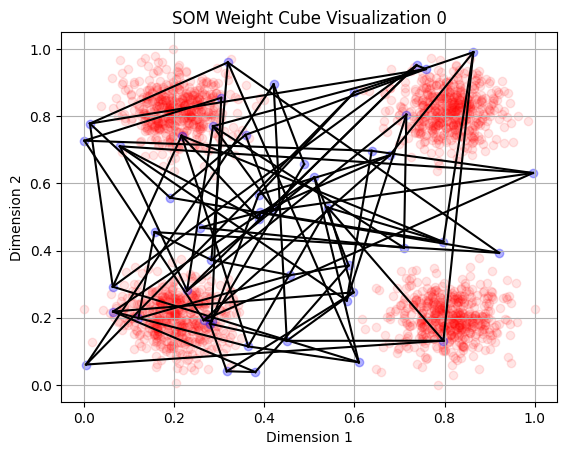

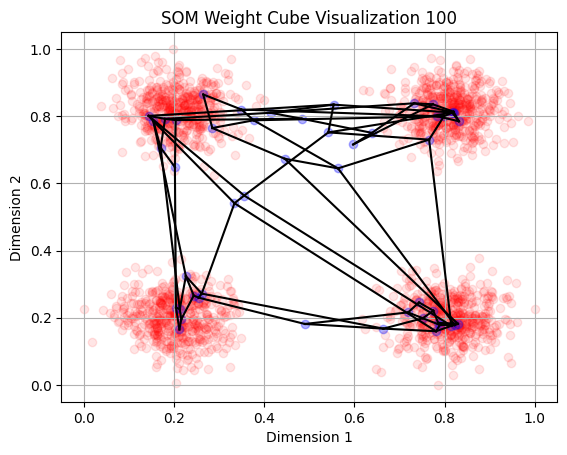

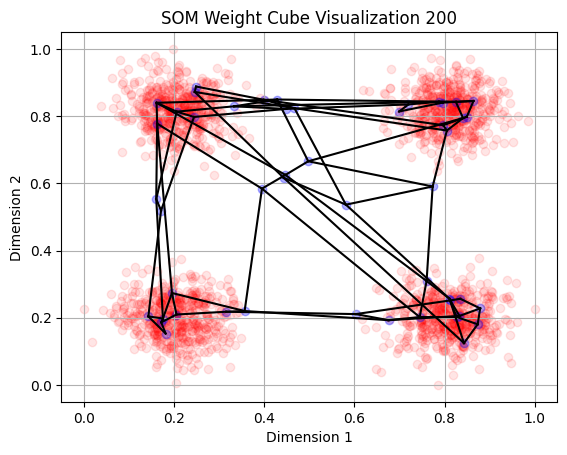

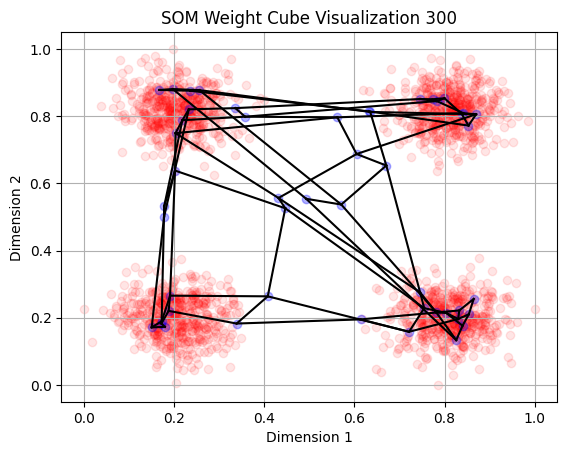

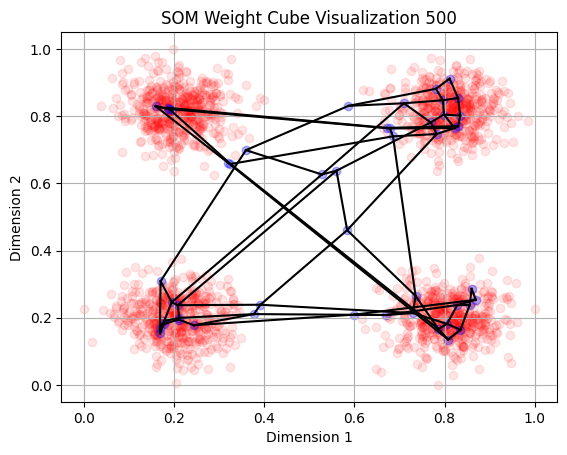

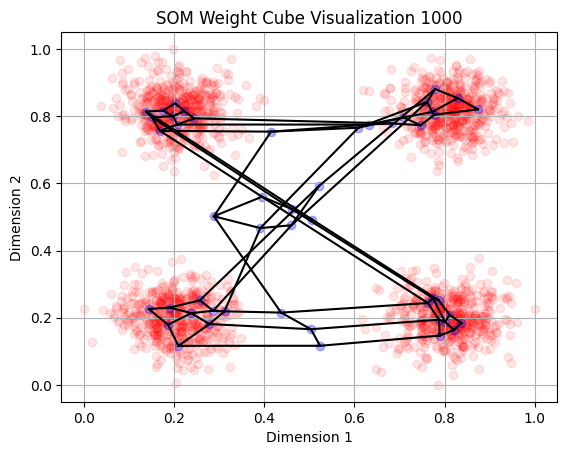

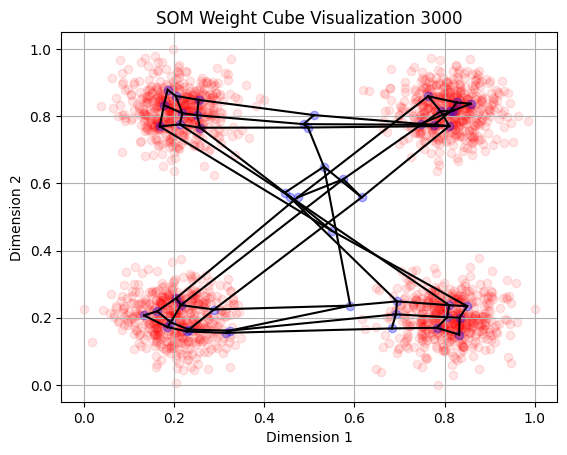

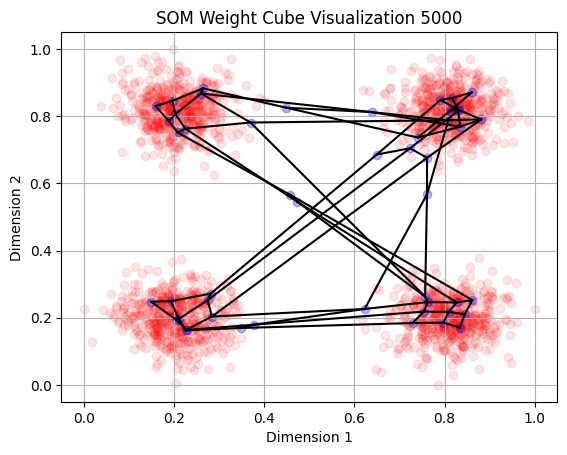

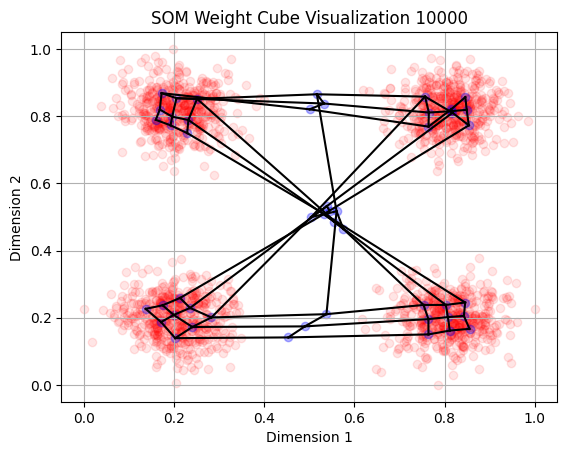

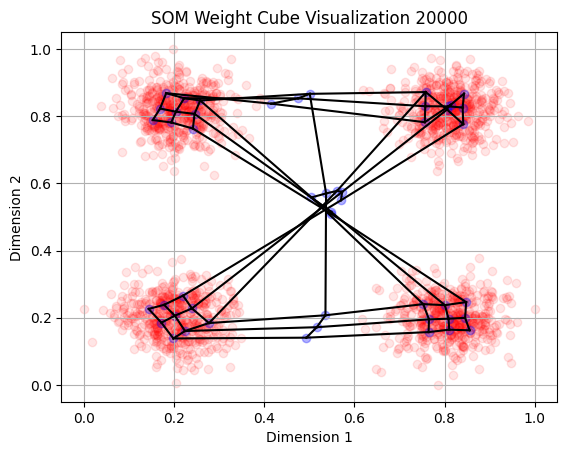

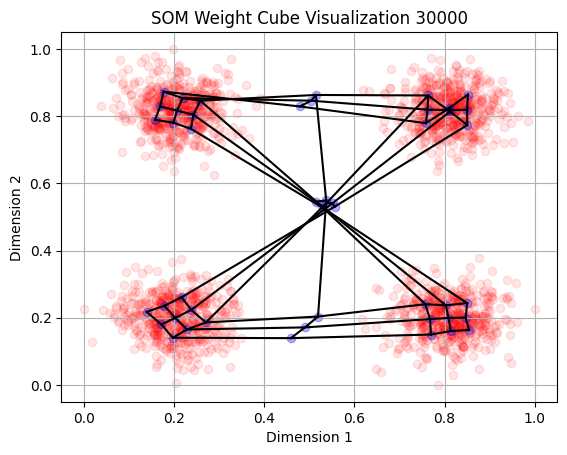

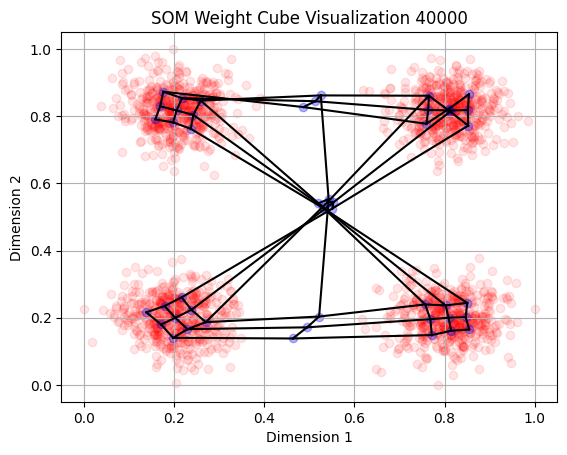

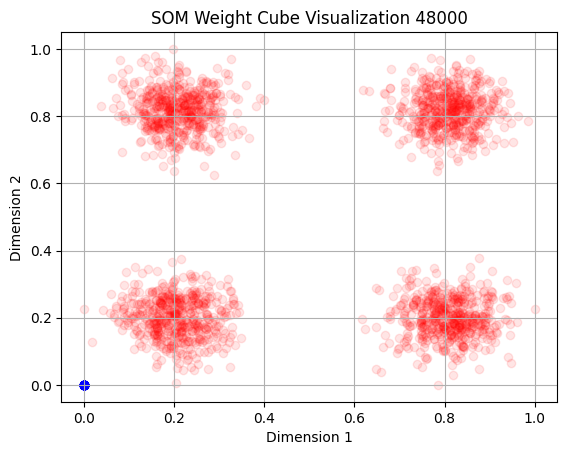

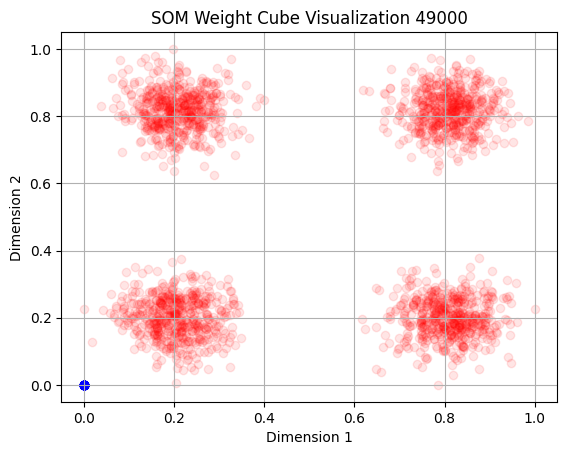

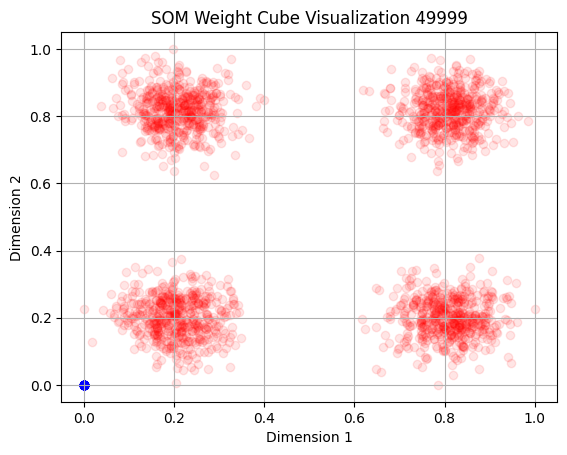

In [72]:
N = 7
for k in np.arange(len(som_model_simple.som_save_state)):
    wcube = som_model_simple.som_save_state[k]
    # Create the plot
    fig, ax = plt.subplots()

    ax.scatter(gaussian_data_4_classes_norm[:, 0], 
                gaussian_data_4_classes_norm[:, 1], alpha=0.1,
               color = 'red', label = "input data")

    for i in range(N):
        for j in range(N):
            ax.scatter(wcube[i, j, 0], 
                       wcube[i, j, 1], color='blue',
                      alpha = 0.3)

    # Connect adjacent neurons
    for i in range(N):
        for j in range(N):
            # Horizontal connections
            if j < N - 1:
                ax.plot([wcube[i, j, 0], 
                         wcube[i, j+1, 0]],
                        [wcube[i, j, 1], 
                         wcube[i, j+1, 1]], color='black')

            # Vertical connections
            if i < N - 1:
                ax.plot([wcube[i, j, 0], 
                         wcube[i+1, j, 0]],
                        [wcube[i, j, 1], 
                         wcube[i+1, j, 1]], color='black')

    # Customize the plot
    ax.set_title(f'SOM Weight Cube Visualization {save_schedule[k]}')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.grid(True)
    
    plt.savefig(f'figs/SOM_weight_cube_time_step_{save_schedule[k]}.png', dpi = 200)

# Show the plot
#plt.show()

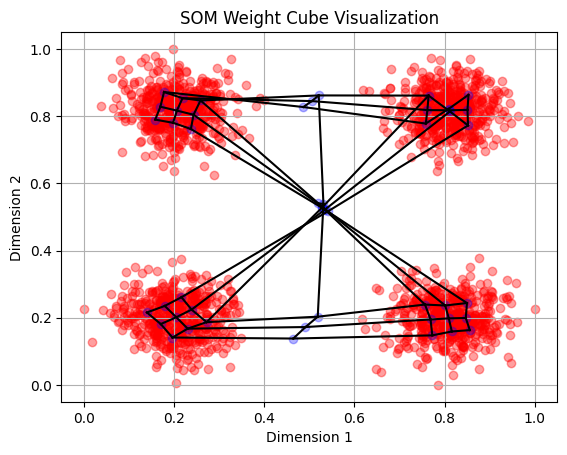

In [73]:
N = 7
# Create the plot
fig, ax = plt.subplots()

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.1,
           color = 'red', label = "input data")

# Plot the neurons (scatter plot)
plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red')

for i in range(N):
    for j in range(N):
        ax.scatter(som_model_simple.weight_cube[i, j, 0], 
                   som_model_simple.weight_cube[i, j, 1], color='blue',
                  alpha = 0.3)

# Connect adjacent neurons
for i in range(N):
    for j in range(N):
        # Horizontal connections
        if j < N - 1:
            ax.plot([som_model_simple.weight_cube[i, j, 0], 
                     som_model_simple.weight_cube[i, j+1, 0]],
                    [som_model_simple.weight_cube[i, j, 1], 
                     som_model_simple.weight_cube[i, j+1, 1]], color='black')

        # Vertical connections
        if i < N - 1:
            ax.plot([som_model_simple.weight_cube[i, j, 0], 
                     som_model_simple.weight_cube[i+1, j, 0]],
                    [som_model_simple.weight_cube[i, j, 1], 
                     som_model_simple.weight_cube[i+1, j, 1]], color='black')

# Customize the plot
ax.set_title('SOM Weight Cube Visualization')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.grid(True)

# Show the plot
plt.show()

In [ ]:
# Define the SOM model, details regarding each parameter can be found in the documentation
som_model = SOM(x_dim = 7, y_dim = 7, input_dim = 2, n_iter=30000,
                       learning_parameters=parameters_schedule,
                       som_type = "cSOM", #neighborhood_decay='exponential',
                       decay_type='schedule', mode = "batch", #neighborhood_decay = "none",#"geometric_series"
                       save_weight_cube_history=True,
                       csom_learning_radius = 1,
                       weight_cube_save_states = save_schedule,
                       #gamma_off=True
                      )
som_model.train(gaussian_data_4_classes_norm)

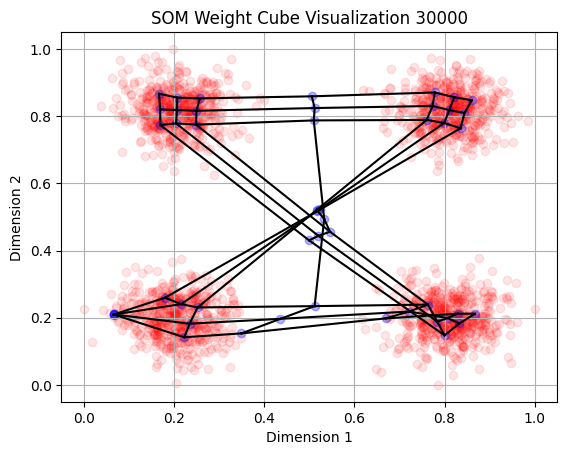

In [76]:
wcube = som_model.weight_cube
# Create the plot
fig, ax = plt.subplots()

ax.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.1,
           color = 'red', label = "input data")

for i in range(N):
    for j in range(N):
        ax.scatter(wcube[i, j, 0], 
                   wcube[i, j, 1], color='blue',
                  alpha = 0.3)

# Connect adjacent neurons
for i in range(N):
    for j in range(N):
        # Horizontal connections
        if j < N - 1:
            ax.plot([wcube[i, j, 0], 
                     wcube[i, j+1, 0]],
                    [wcube[i, j, 1], 
                     wcube[i, j+1, 1]], color='black')

        # Vertical connections
        if i < N - 1:
            ax.plot([wcube[i, j, 0], 
                     wcube[i+1, j, 0]],
                    [wcube[i, j, 1], 
                     wcube[i+1, j, 1]], color='black')

# Customize the plot
ax.set_title(f'SOM Weight Cube Visualization 30000')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.grid(True)

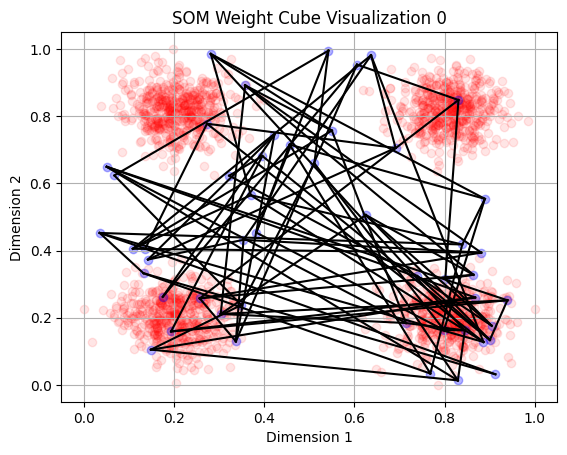

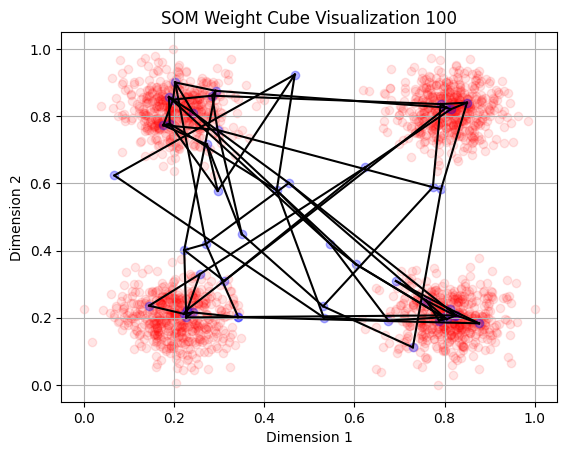

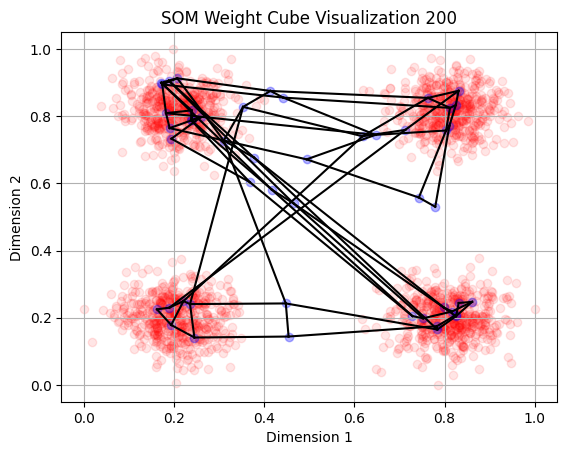

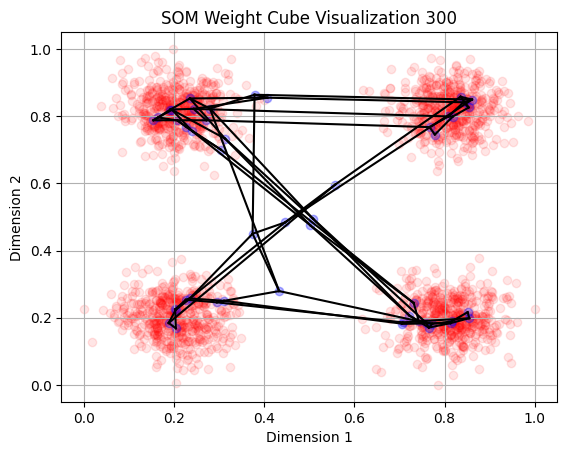

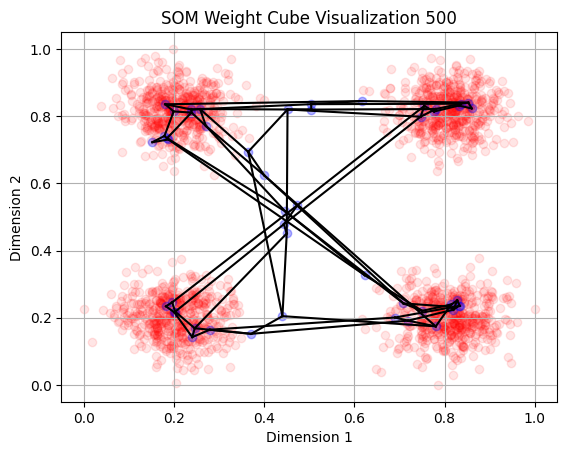

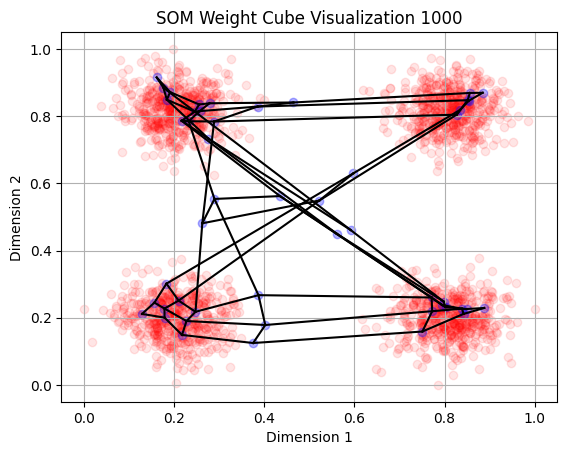

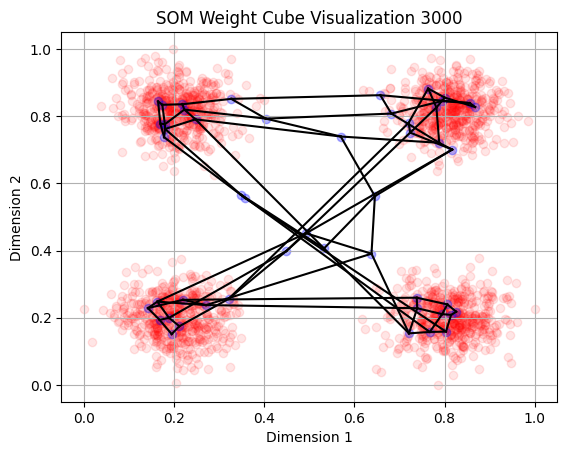

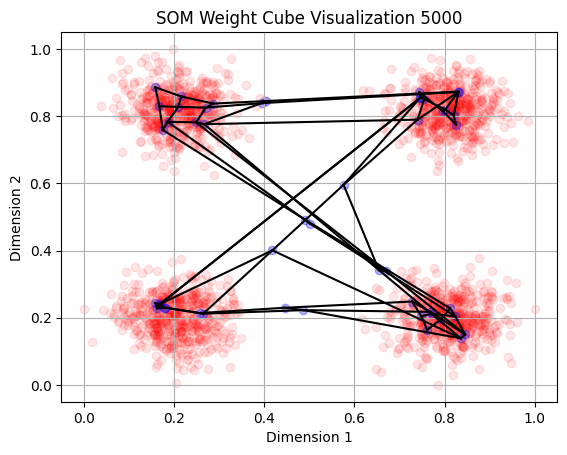

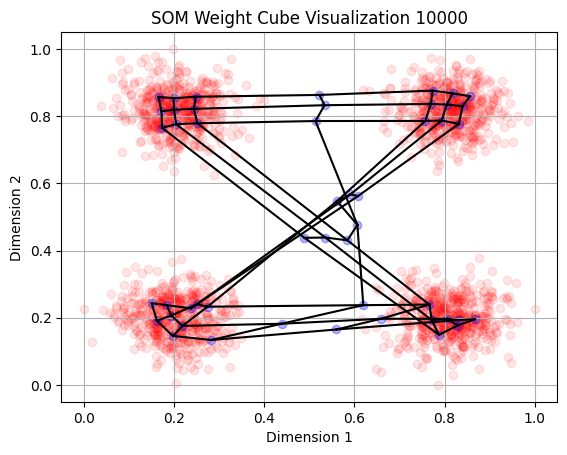

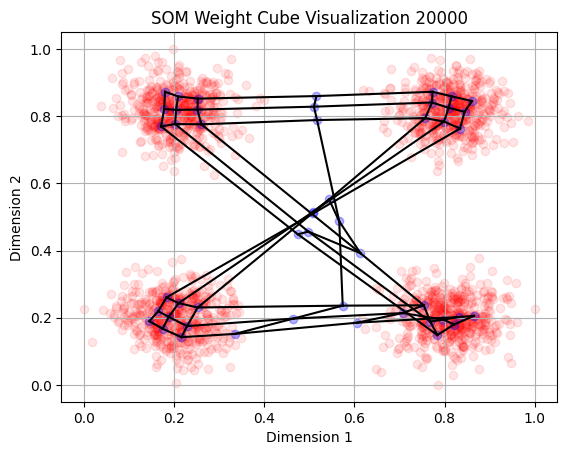

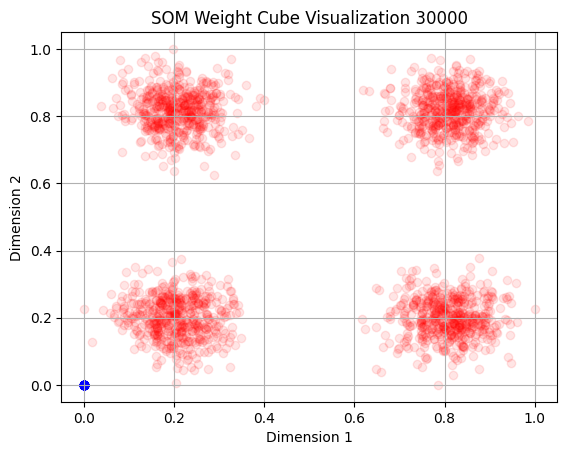

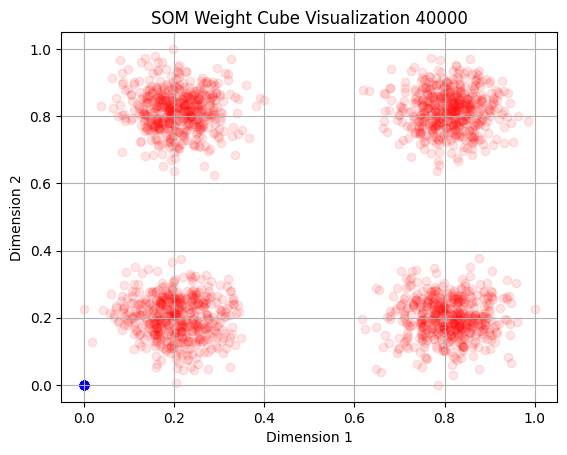

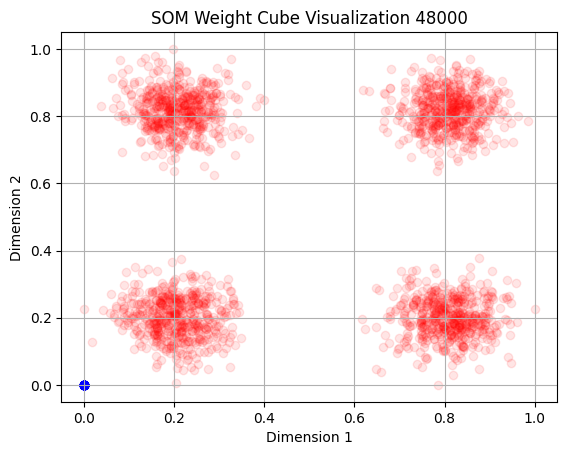

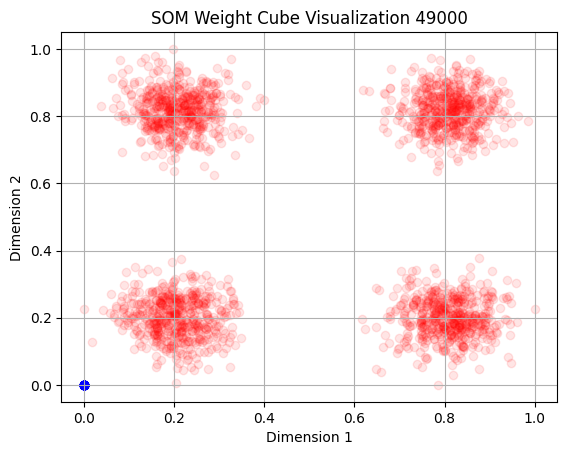

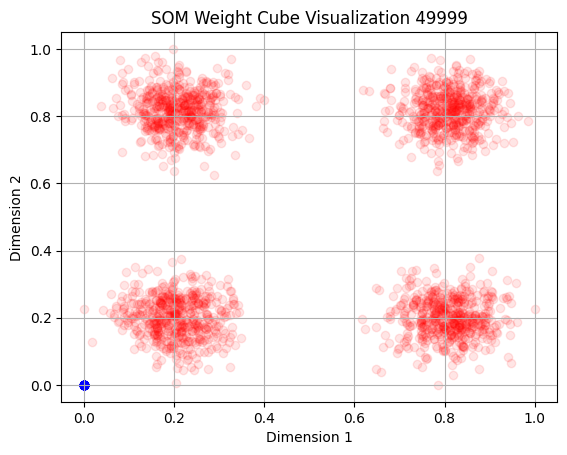

In [77]:
N = 7
for k in np.arange(len(som_model_simple.som_save_state)):
    wcube = som_model.som_save_state[k]
    # Create the plot
    fig, ax = plt.subplots()

    ax.scatter(gaussian_data_4_classes_norm[:, 0], 
                gaussian_data_4_classes_norm[:, 1], alpha=0.1,
               color = 'red', label = "input data")

    for i in range(N):
        for j in range(N):
            ax.scatter(wcube[i, j, 0], 
                       wcube[i, j, 1], color='blue',
                      alpha = 0.3)

    # Connect adjacent neurons
    for i in range(N):
        for j in range(N):
            # Horizontal connections
            if j < N - 1:
                ax.plot([wcube[i, j, 0], 
                         wcube[i, j+1, 0]],
                        [wcube[i, j, 1], 
                         wcube[i, j+1, 1]], color='black')

            # Vertical connections
            if i < N - 1:
                ax.plot([wcube[i, j, 0], 
                         wcube[i+1, j, 0]],
                        [wcube[i, j, 1], 
                         wcube[i+1, j, 1]], color='black')

    # Customize the plot
    ax.set_title(f'SOM Weight Cube Visualization {save_schedule[k]}')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.grid(True)

In [113]:
parameters_schedule[0] = (2000, 0.8, 0.0001, 5)
parameters_schedule[1] = (8000, 0.1, 0.0008, 1) # 0.00009
parameters_schedule[2] = (20000, 0.05, 0.0008, 0.1) # 0.00008
parameters_schedule[3] = (100000, 0.005, 0.0001, 0.01) # 0.00005

In [125]:
som_model_10k = SOM(x_dim = 7, y_dim = 7, input_dim = 2, n_iter=10001,
                       learning_parameters=parameters_schedule,
                       som_type = "cSOM", #neighborhood_decay='exponential',
                       decay_type='schedule', mode = "batch", #neighborhood_decay = "none",#"geometric_series"
                       save_weight_cube_history=True,
                       csom_learning_radius = 1,
                       weight_cube_save_states = save_schedule,
                       #gamma_off=True
                      )
som_model_10k.train(gaussian_data_4_classes_norm)

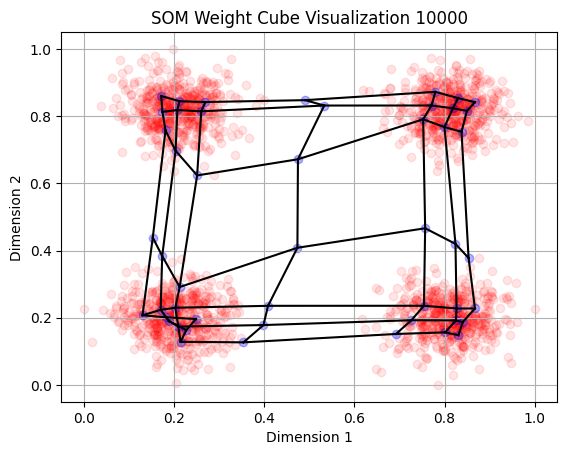

In [126]:
wcube = som_model_10k.weight_cube
# Create the plot
fig, ax = plt.subplots()

ax.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.1,
           color = 'red', label = "input data")

for i in range(N):
    for j in range(N):
        ax.scatter(wcube[i, j, 0], 
                   wcube[i, j, 1], color='blue',
                  alpha = 0.3)

# Connect adjacent neurons
for i in range(N):
    for j in range(N):
        # Horizontal connections
        if j < N - 1:
            ax.plot([wcube[i, j, 0], 
                     wcube[i, j+1, 0]],
                    [wcube[i, j, 1], 
                     wcube[i, j+1, 1]], color='black')

        # Vertical connections
        if i < N - 1:
            ax.plot([wcube[i, j, 0], 
                     wcube[i+1, j, 0]],
                    [wcube[i, j, 1], 
                     wcube[i+1, j, 1]], color='black')

# Customize the plot
ax.set_title(f'SOM Weight Cube Visualization 10000')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.grid(True)

In [118]:
parameters_schedule[0] = (2000, 0.8, 0.0001, 5)
parameters_schedule[1] = (8000, 0.1, 0.0008, 1) # 0.00009
parameters_schedule[2] = (20000, 0.05, 0.0008, 0.1) # 0.00008
parameters_schedule[3] = (100000, 0.005, 0.0001, 0.01) # 0.00005

In [121]:
som_model_10k = SOM(x_dim = 7, y_dim = 7, input_dim = 2, n_iter=10001,
                       learning_parameters=parameters_schedule,
                       som_type = "cSOM", #neighborhood_decay='exponential',
                       decay_type='schedule', mode = "batch", #neighborhood_decay = "none",#"geometric_series"
                       save_weight_cube_history=True,
                       csom_learning_radius = 1,
                       weight_cube_save_states = save_schedule,
                       #gamma_off=True
                      )
som_model_10k.train(gaussian_data_4_classes_norm)

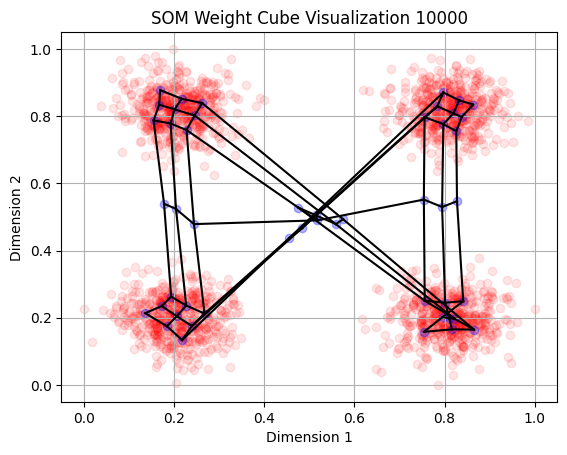

In [122]:
wcube = som_model_10k.weight_cube
# Create the plot
fig, ax = plt.subplots()

ax.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.1,
           color = 'red', label = "input data")

for i in range(N):
    for j in range(N):
        ax.scatter(wcube[i, j, 0], 
                   wcube[i, j, 1], color='blue',
                  alpha = 0.3)

# Connect adjacent neurons
for i in range(N):
    for j in range(N):
        # Horizontal connections
        if j < N - 1:
            ax.plot([wcube[i, j, 0], 
                     wcube[i, j+1, 0]],
                    [wcube[i, j, 1], 
                     wcube[i, j+1, 1]], color='black')

        # Vertical connections
        if i < N - 1:
            ax.plot([wcube[i, j, 0], 
                     wcube[i+1, j, 0]],
                    [wcube[i, j, 1], 
                     wcube[i+1, j, 1]], color='black')

# Customize the plot
ax.set_title(f'SOM Weight Cube Visualization 10000')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.grid(True)

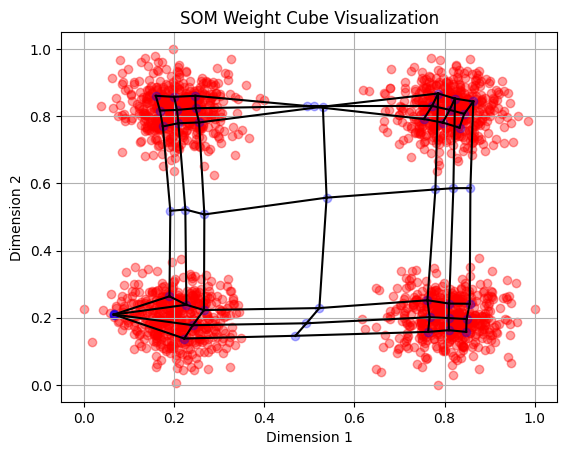

In [51]:

N = 7
# Create the plot
fig, ax = plt.subplots()

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.1,
           color = 'red', label = "input data")

# Plot the neurons (scatter plot)
plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red')

for i in range(N):
    for j in range(N):
        ax.scatter(som_model_simple.weight_cube[i, j, 0], 
                   som_model_simple.weight_cube[i, j, 1], color='blue',
                  alpha = 0.3)

# Connect adjacent neurons
for i in range(N):
    for j in range(N):
        # Horizontal connections
        if j < N - 1:
            ax.plot([som_model_simple.weight_cube[i, j, 0], 
                     som_model_simple.weight_cube[i, j+1, 0]],
                    [som_model_simple.weight_cube[i, j, 1], 
                     som_model_simple.weight_cube[i, j+1, 1]], color='black')

        # Vertical connections
        if i < N - 1:
            ax.plot([som_model_simple.weight_cube[i, j, 0], 
                     som_model_simple.weight_cube[i+1, j, 0]],
                    [som_model_simple.weight_cube[i, j, 1], 
                     som_model_simple.weight_cube[i+1, j, 1]], color='black')

# Customize the plot
ax.set_title('SOM Weight Cube Visualization')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.grid(True)

# Show the plot
plt.show()

In [65]:
test = np.array([1,2,3,4,5,6,7,8,9]).reshape(3,3), np.array([1,2,3,4,5,6,7,8,9]).reshape(3,3)

In [67]:
test = np.concatenate((test, np.array([1,2,3,4,5,6,7,8,9]).reshape(3,3)))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [64]:
test

((array([[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]),
  array([[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]])),
 array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]))

In [49]:
np.append(np.array([1,2,3,4,5,6,7,8,9]).reshape(3,3),
         np.array([1,2,3,4,5,6,7,8,9]).reshape(3,3))

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9])

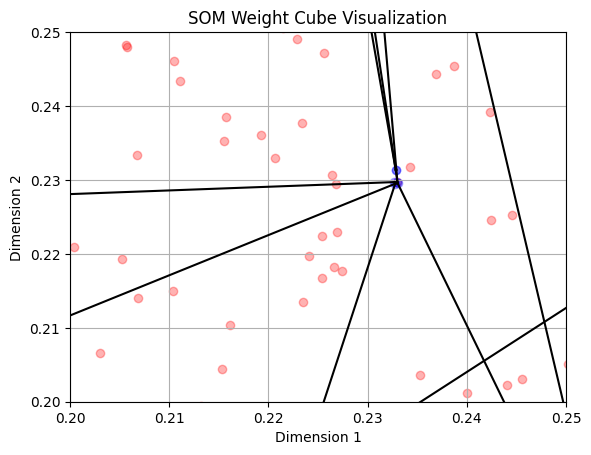

In [19]:
N = 7
# Create the plot
fig, ax = plt.subplots()

# Plot the neurons (scatter plot)
plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red')

for i in range(N):
    for j in range(N):
        ax.scatter(som_model_simple.weight_cube[i, j, 0], 
                   som_model_simple.weight_cube[i, j, 1], color='blue',
                  alpha = 0.3)

# Connect adjacent neurons
for i in range(N):
    for j in range(N):
        # Horizontal connections
        if j < N - 1:
            ax.plot([som_model_simple.weight_cube[i, j, 0], 
                     som_model_simple.weight_cube[i, j+1, 0]],
                    [som_model_simple.weight_cube[i, j, 1], 
                     som_model_simple.weight_cube[i, j+1, 1]], color='black')

        # Vertical connections
        if i < N - 1:
            ax.plot([som_model_simple.weight_cube[i, j, 0], 
                     som_model_simple.weight_cube[i+1, j, 0]],
                    [som_model_simple.weight_cube[i, j, 1], 
                     som_model_simple.weight_cube[i+1, j, 1]], color='black')

# Customize the plot
ax.set_title('SOM Weight Cube Visualization')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.grid(True)
ax.set_xlim(0.2, 0.25)
ax.set_ylim(0.2, 0.25)

# Show the plot
plt.show()

Here I will show some of the diagnostic tools that are built-in to the SOM class. These can be helpful to find issues if you beileve the trained SOM is not adequent

In [33]:
# Shows the number of time each neuron won the BMU
som_model_simple.weight_cube_history

array([[3671., 1577., 1170.,  103., 1904., 1575., 3140.],
       [1682., 1514.,  657.,   77., 1197.,  747., 1381.],
       [ 828.,  497.,  346.,   36.,  573.,  582.,  694.],
       [ 234.,  143.,   10.,   22.,  197.,  151.,  186.],
       [2026., 1335.,  464.,  110., 1032.,  706., 1643.],
       [ 901.,  677.,  783.,  141.,  831.,  426., 2914.],
       [3238., 1811.,  397.,  197., 1790.,  997., 2687.]])

In [38]:
# Shows the update radius at each step, the cSOM is normally limited
# To only updating the emmidiate neighbors
som_model_simple.save_neighborhood_function[:,:,4]

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.5 , 0.25, 0.  , 0.  , 0.  , 0.  ]])

Text(0, 0.5, 'bais matrix values')

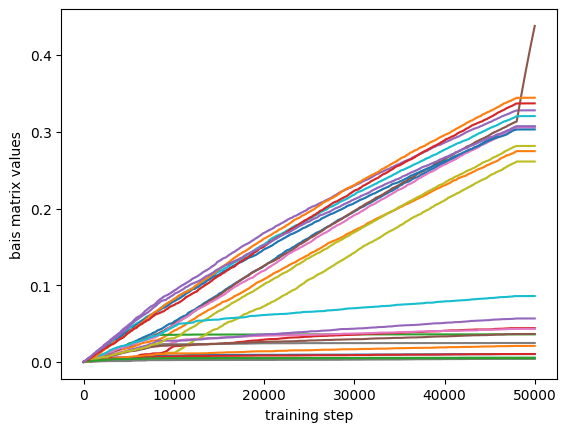

In [156]:
# Shows bais matrix evolution over time, expect values between 0 and 1
# Usually you dont want any neuron getting close to 1
for i in np.arange(25):
    plt.plot(np.reshape(som_model_simple.bais_matrix_history, (5*5, (som_model_simple.bais_matrix_history).shape[-1]))[i])
    
#plt.xlim(0,1000)
plt.xlabel("training step")
plt.ylabel("bais matrix values")

In [157]:
# This is the value that suppresses neurons from winning too often
supression_mat_vector = som_model_simple.suppresion_matrix_history.reshape(5*5,(som_model_simple.suppresion_matrix_history).shape[-1])

Text(0, 0.5, 'bais matrix values')

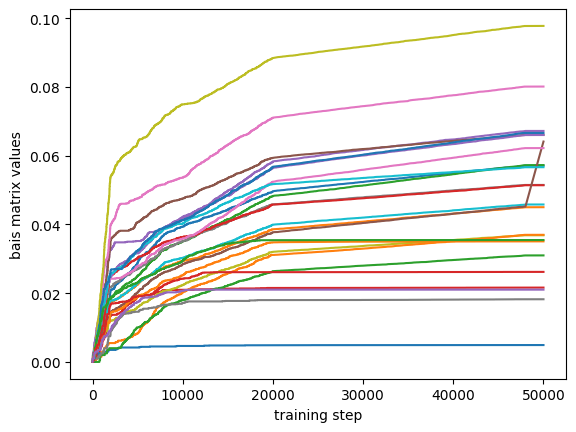

In [19]:
# Shows bais matrix evolution over time, expect values between 0 and 1
# Usually you dont want any neuron getting close to 1
for i in np.arange(25):
    plt.plot(np.reshape(som_model_simple.bais_matrix_history, (7*7, (som_model_simple.bais_matrix_history).shape[-1]))[i])
    
#plt.xlim(0,1000)
plt.xlabel("training step")
plt.ylabel("bais matrix values")

Text(0, 0.5, 'Supression matrix values')

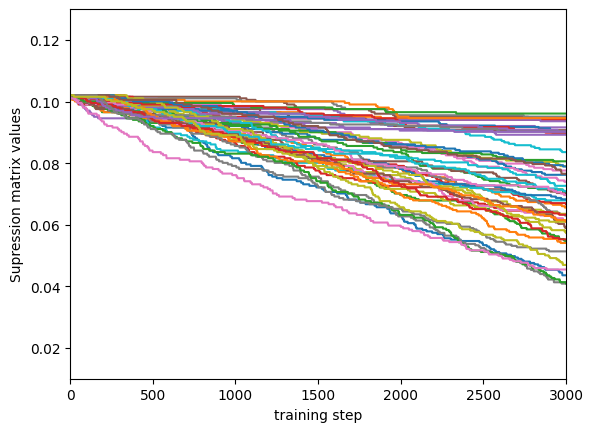

In [131]:
#ax, plt = plt.figure(s)
for i in np.arange(7*7):
    plt.plot(supression_mat_vector[i])
    
plt.xlim(0,3000)
plt.ylim(0.01,0.13)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")

Text(0, 0.5, 'Supression matrix values')

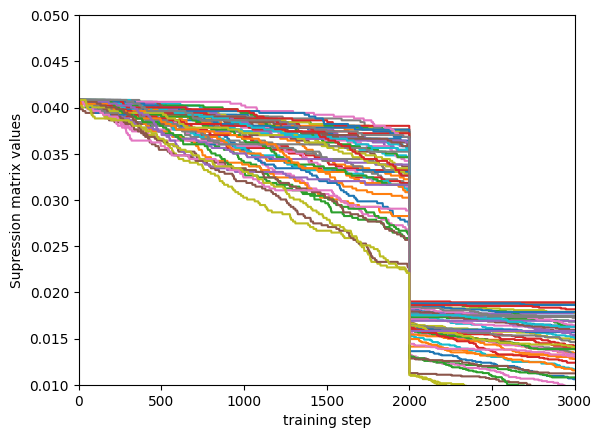

In [117]:
#ax, plt = plt.figure(s)
for i in np.arange(7*7):
    plt.plot(supression_mat_vector[i])
    
plt.xlim(0,3000)
plt.ylim(0.01,0.05)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")

Value that is suppressing neurons from winning too much for each neuron.
Typically we want these values to be between 0 and 1, falling bellow
One is acceptable but it can sometimes cause issues which is why we
Keep beta low.

Text(0, 0.5, 'Supression matrix values')

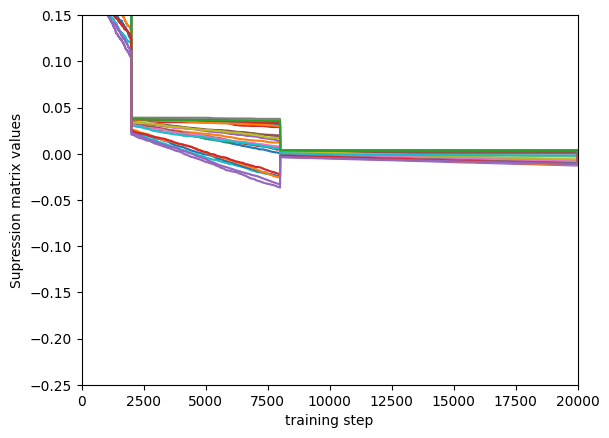

In [159]:

for i in np.arange(5*5):
    plt.plot(supression_mat_vector[i])
    
plt.xlim(0,20000)
plt.ylim(-0.25,0.15)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")

Text(0, 0.5, 'Supression matrix values')

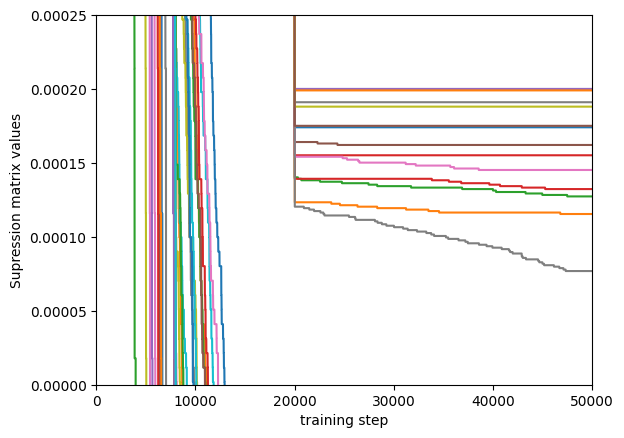

In [150]:

for i in np.arange(7*7):
    plt.plot(supression_mat_vector[i])
    
plt.xlim(0,50000)
plt.ylim(0,0.00025)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")

Text(0.5, 1.0, 'cSOM')

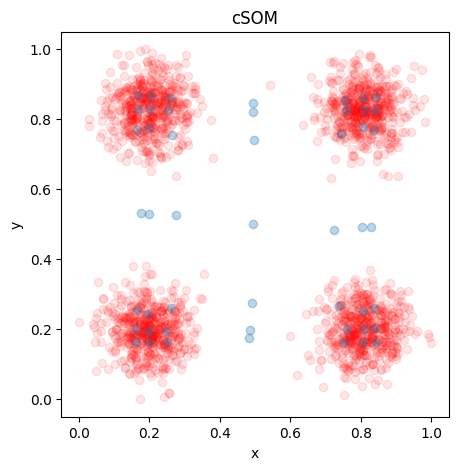

In [68]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.1,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
            alpha = 0.3,
           label = "weights")
#plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM") 

Text(0.5, 1.0, 'cSOM')

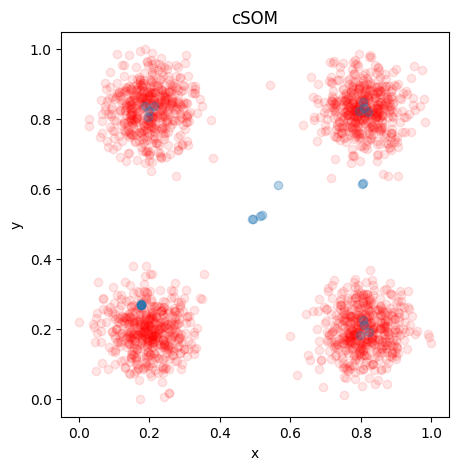

In [161]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.1,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(5*5,2)[:,0],
           som_model_simple.weight_cube.reshape(5*5,2)[:,1],
            alpha = 0.3,
           label = "weights")
#plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM") 

Text(0.5, 1.0, 'cSOM')

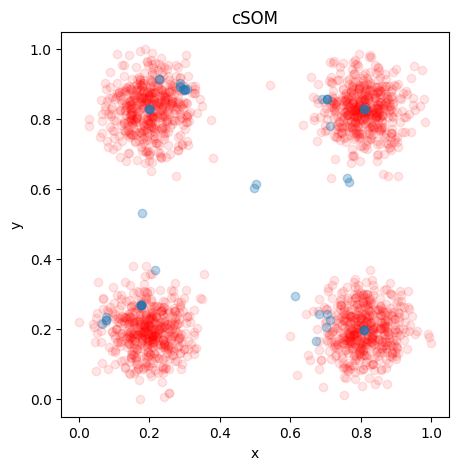

In [133]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.1,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
            alpha = 0.3,
           label = "weights")
#plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM") 

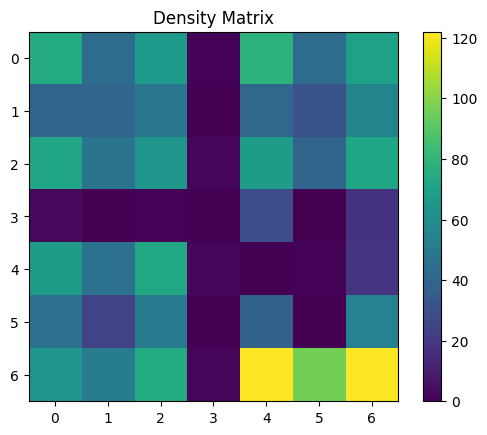

In [64]:
U_MAT = calculate_u_matrix(som_model_simple.weight_cube)
DENS_MAT = calculate_density_matrix(som_model_simple.weight_cube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm)
display_density_matrix(DENS_MAT)

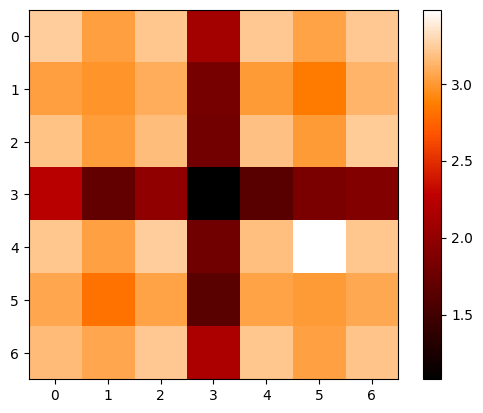

In [62]:
plt.imshow(np.log10(som_model_simple.weight_cube_history), 
           interpolation="nearest", origin="upper",
          cmap = 'gist_heat')
plt.colorbar()
plt.show()

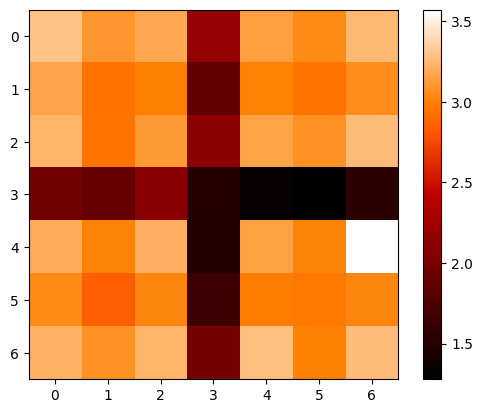

In [81]:
plt.imshow(np.log10(som_model_simple.weight_cube_history), 
           interpolation="nearest", origin="upper",
          cmap = 'gist_heat')
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'cSOM')

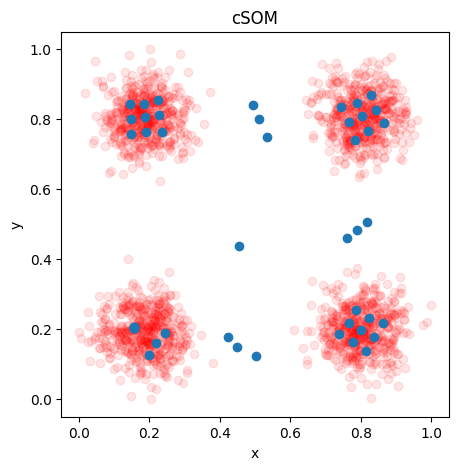

In [63]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.1,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
#plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM") 

Text(0.5, 1.0, 'cSOM')

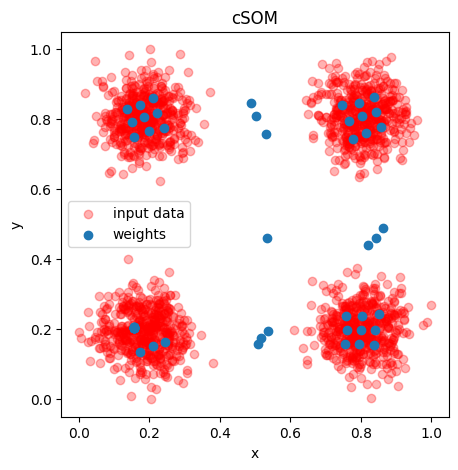

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM") # default neighborhood decay
# Note a bit odd that the bottom left corner seems to have some issues

Text(0.5, 1.0, 'cSOM')

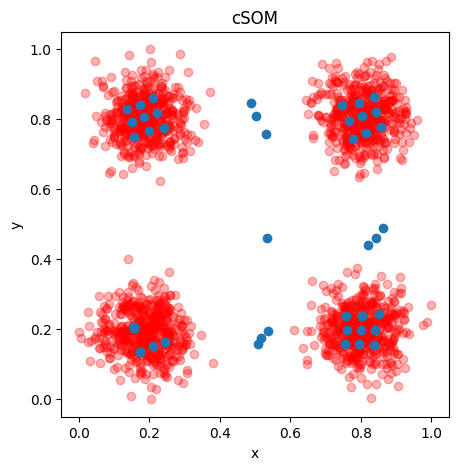

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
#plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM") # default neighborhood decay
# Note a bit odd that the bottom left corner seems to have some issues

Text(0.5, 1.0, 'cSOM')

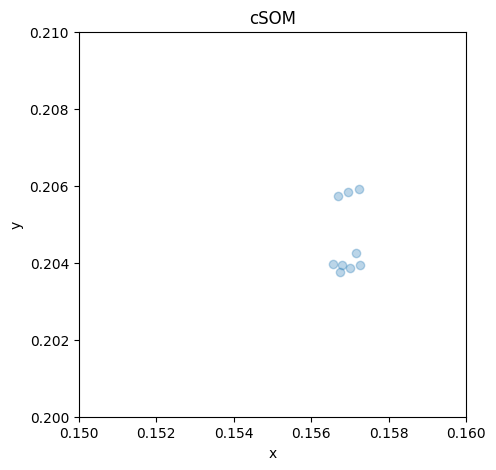

In [57]:
fig, ax = plt.subplots(figsize=(5, 5))


plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights", alpha = 0.3)
#plt.legend()
plt.xlim(0.15, 0.16)
plt.ylim(0.2, 0.21)
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM") # default neighborhood decay
# Note a bit odd that the bottom left corner seems to have some issues

In [55]:
som_model_simple.weight_cube

array([[[0.17436117, 0.13537375],
        [0.20900283, 0.15319816],
        [0.24539934, 0.16432049],
        [0.50719358, 0.15850593],
        [0.75528099, 0.15833341],
        [0.76213262, 0.19779956],
        [0.75952414, 0.23652176]],

       [[0.15675152, 0.20374697],
        [0.15700964, 0.20385072],
        [0.15725804, 0.20395343],
        [0.51728398, 0.1755606 ],
        [0.7954786 , 0.15797173],
        [0.80162007, 0.19688632],
        [0.80410759, 0.23706411]],

       [[0.1565498 , 0.20395778],
        [0.15680367, 0.20395083],
        [0.15716127, 0.20424089],
        [0.53595465, 0.19570044],
        [0.83650673, 0.15466807],
        [0.83953824, 0.19899008],
        [0.85050904, 0.24304292]],

       [[0.15669413, 0.20573815],
        [0.1569523 , 0.20583389],
        [0.1572266 , 0.20592565],
        [0.53441982, 0.46064607],
        [0.82012398, 0.44063704],
        [0.8438414 , 0.46136088],
        [0.86456116, 0.48982573]],

       [[0.15753564, 0.74965838],
      

In [54]:
np.min(0)

np.int64(0)

In [53]:
np.where(np.array([1,1,1]) == 1)

(array([0, 1, 2]),)

In [49]:
som_model_simple.save_neighborhood_function[:,:,104]

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0.5, 1. , 0.5],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

## Experimentation with parameters examples
From here we will show some of the different parameters I tried to use to show how if affects the cSOM learning. Feel free to ignore these and just treat the as examples but I believe the are informative to watch. Feel free to play with the different parameters and see the different results you get!

Text(0.5, 1.0, 'cSOM, neighborhood radius = 0')

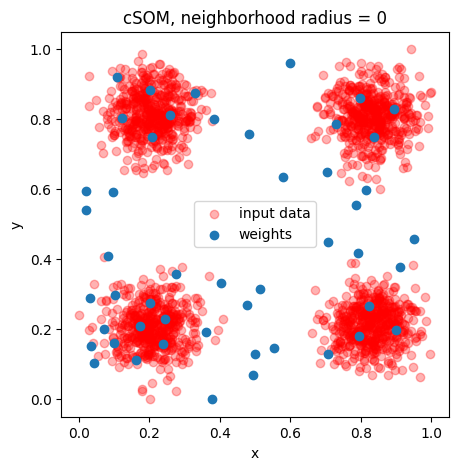

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM, neighborhood radius = 0") # decay -> none

Text(0.5, 1.0, 'cSOM, neighborhood radius = 1')

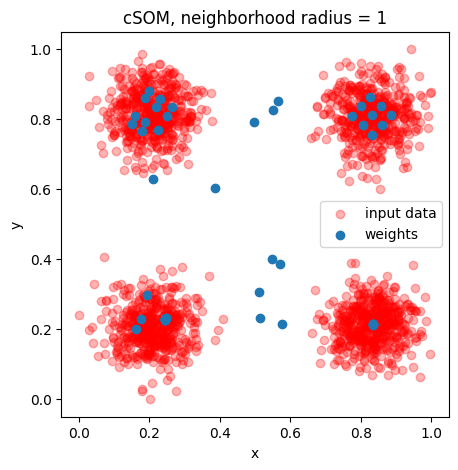

In [68]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM, neighborhood radius = 1") # none

Text(0.5, 1.0, 'cSOM, neighborhood radius = 1')

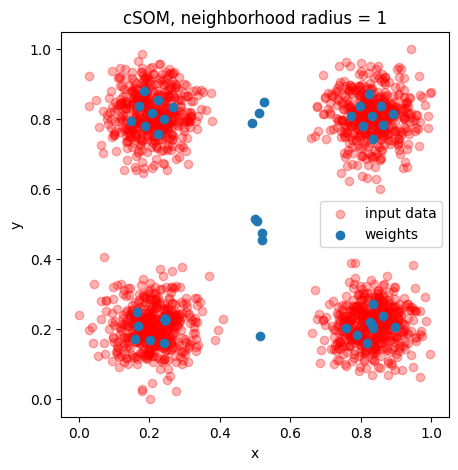

In [73]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM, neighborhood radius = 1") # geometric series

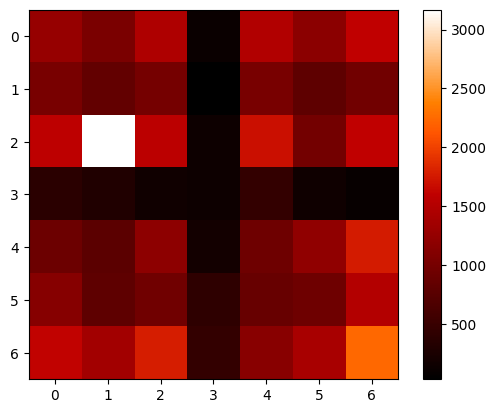

In [59]:
plt.imshow(som_model_simple.weight_cube_history, interpolation="nearest", origin="upper",
          cmap = 'gist_heat')
plt.colorbar()
plt.show()

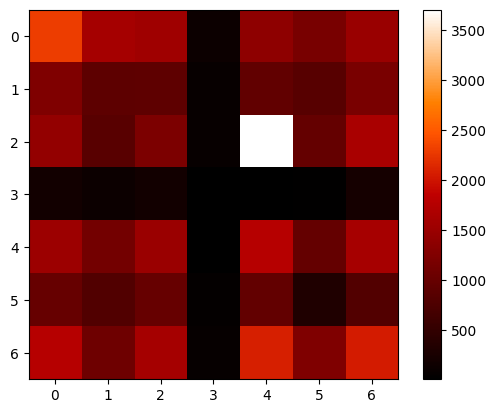

In [79]:
plt.imshow(som_model_simple.weight_cube_history, interpolation="nearest", origin="upper",
          cmap = 'gist_heat')
plt.colorbar()
plt.show()

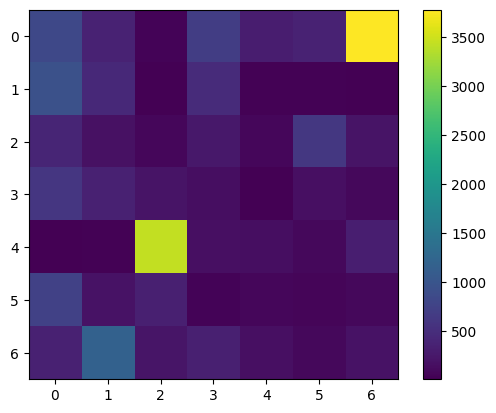

In [38]:
plt.imshow(som_model_simple.weight_cube_history, interpolation="nearest", origin="upper")
plt.colorbar()
plt.show()

In [19]:
som_model_simple.weight_cube_history # not doing the whole (spreading out how wins) very well

array([[3.000e+00, 1.230e+02, 3.803e+03, 2.680e+02, 2.170e+02, 1.430e+02,
        3.490e+02],
       [1.700e+02, 0.000e+00, 2.510e+02, 4.700e+01, 2.120e+03, 1.210e+02,
        1.000e+02],
       [4.232e+03, 5.100e+01, 4.100e+01, 2.510e+02, 1.860e+02, 1.840e+02,
        1.110e+02],
       [3.700e+01, 5.000e+00, 3.600e+01, 2.690e+02, 1.800e+02, 8.200e+01,
        1.140e+02],
       [1.270e+03, 5.420e+02, 4.000e+00, 1.600e+02, 1.780e+02, 1.140e+02,
        1.430e+02],
       [5.370e+02, 3.340e+02, 1.100e+01, 1.080e+02, 9.500e+01, 8.100e+01,
        1.510e+02],
       [1.103e+03, 6.310e+02, 7.000e+01, 3.000e+02, 2.850e+02, 1.760e+02,
        2.130e+02]])

In [17]:
som_model_simple.weight_cube_history

array([[4.314e+03, 4.590e+02, 6.300e+01, 8.110e+02, 6.960e+02, 4.390e+02,
        2.732e+03],
       [3.550e+02, 3.430e+02, 3.640e+02, 1.200e+01, 4.730e+02, 3.000e+02,
        3.650e+02],
       [6.400e+01, 1.580e+02, 2.180e+02, 2.280e+02, 3.000e+00, 1.920e+02,
        1.190e+02],
       [7.900e+02, 2.230e+02, 1.610e+02, 9.800e+01, 2.880e+02, 1.300e+01,
        1.530e+02],
       [2.917e+03, 1.820e+02, 1.640e+02, 1.460e+02, 1.210e+02, 7.700e+01,
        1.600e+02],
       [1.690e+02, 2.230e+02, 2.030e+02, 1.550e+02, 5.800e+01, 1.570e+02,
        0.000e+00],
       [3.660e+02, 5.800e+01, 1.000e+02, 1.400e+02, 8.400e+01, 8.600e+01,
        0.000e+00]])

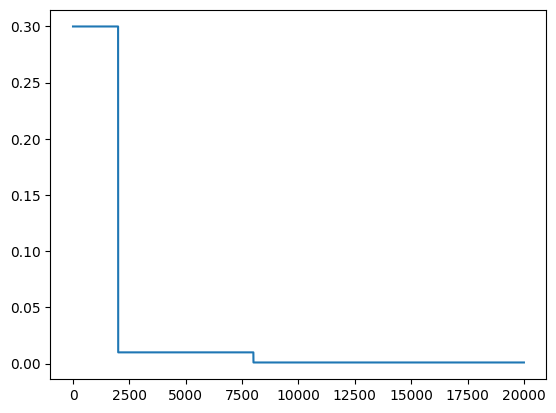

In [18]:
plt.plot(som_model_simple.learning_rate_history)

Here we plot a cSOM with a neighborhood radius of 2, interestingly enough it almost looks like this weights are pointing to the sections between the clusters instead of on the clusters, at least for the top 2, the bottom two seem to be normalish

In [24]:
(1/(7*7)) * 0.3

0.006122448979591836

In [25]:
som_model_simple.suppresion_matrix_history[:,:,1]

array([[0.00612245, 0.00612245, 0.00582245, 0.00612245, 0.00612245,
        0.00612245, 0.00612245],
       [0.00612245, 0.00612245, 0.00612245, 0.00612245, 0.00612245,
        0.00612245, 0.00612245],
       [0.00612245, 0.00612245, 0.00612245, 0.00612245, 0.00612245,
        0.00612245, 0.00612245],
       [0.00612245, 0.00612245, 0.00612245, 0.00612245, 0.00612245,
        0.00612245, 0.00612245],
       [0.00612245, 0.00612245, 0.00612245, 0.00612245, 0.00612245,
        0.00612245, 0.00612245],
       [0.00612245, 0.00612245, 0.00612245, 0.00582245, 0.00612245,
        0.00612245, 0.00612245],
       [0.00612245, 0.00612245, 0.00612245, 0.00612245, 0.00612245,
        0.00612245, 0.00612245]])

Text(0.5, 1.0, 'cSOM, neighborhood radius = 2')

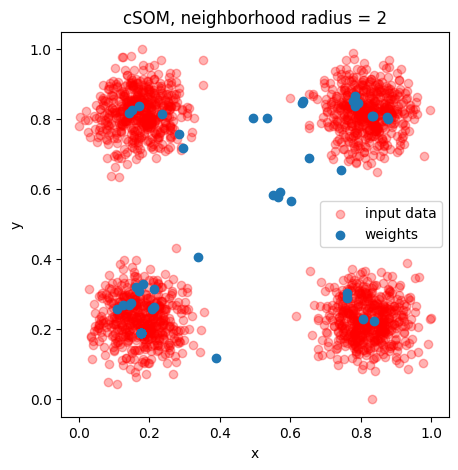

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM, neighborhood radius = 2") # exponential

Text(0.5, 1.0, 'cSOM, neighborhood radius = 2')

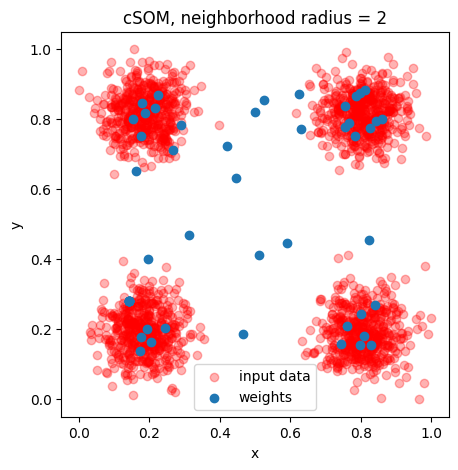

In [69]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM, neighborhood radius = 2") # exponential

Text(0.5, 1.0, 'cSOM, neighborhood radius = 2 (geometric_series)')

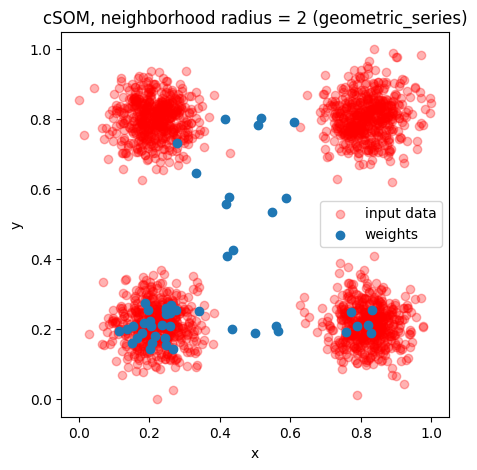

In [17]:
# retried, this set of parameters is not coinsistent
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM, neighborhood radius = 2 (geometric_series)")

Text(0.5, 1.0, 'cSOM, neighborhood radius = 2 (geometric_series)')

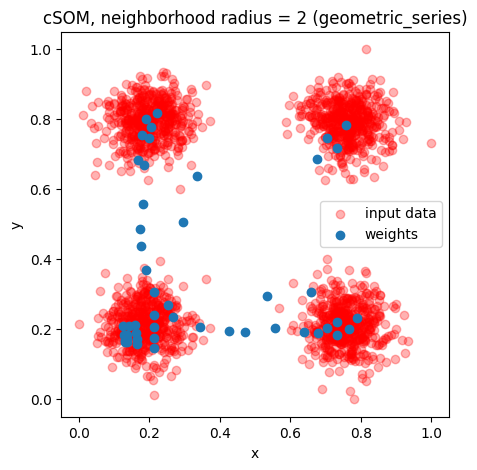

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM, neighborhood radius = 2 (geometric_series)")

Text(0, 0.5, 'y')

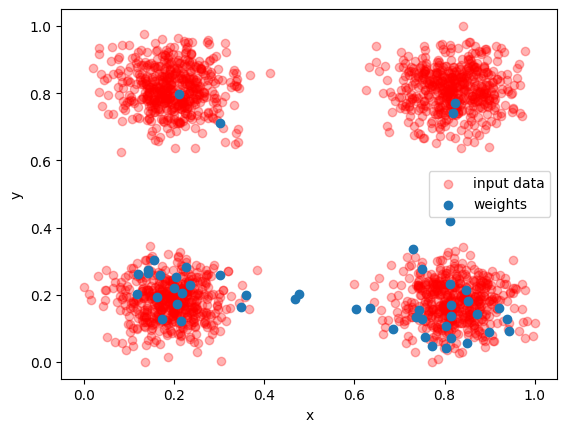

In [70]:
plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'y')

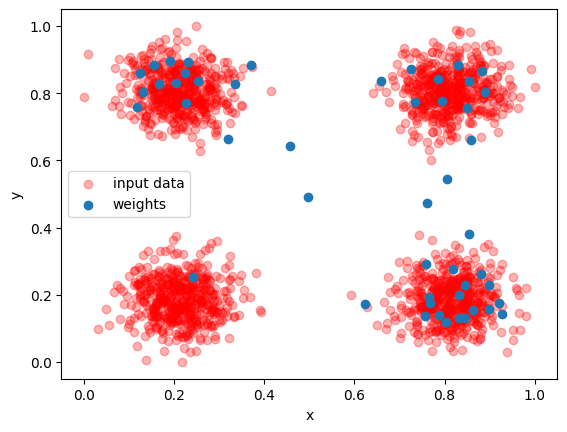

In [43]:
plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

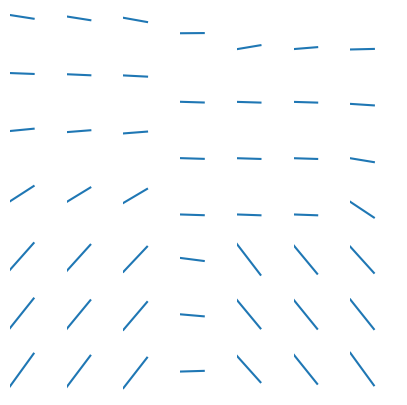

In [80]:
plot_SOM_gird_neurons(som_model_simple.weight_cube)

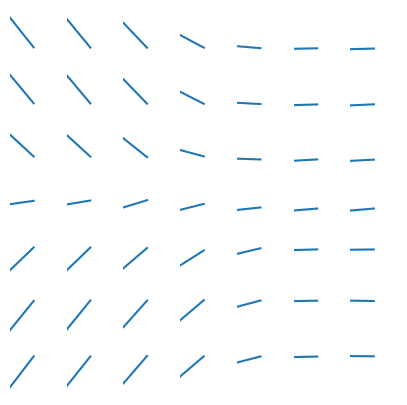

In [26]:
plot_SOM_gird_neurons(som_model_simple.weight_cube)

Text(0.5, 1.0, 'n_iter = 10000')

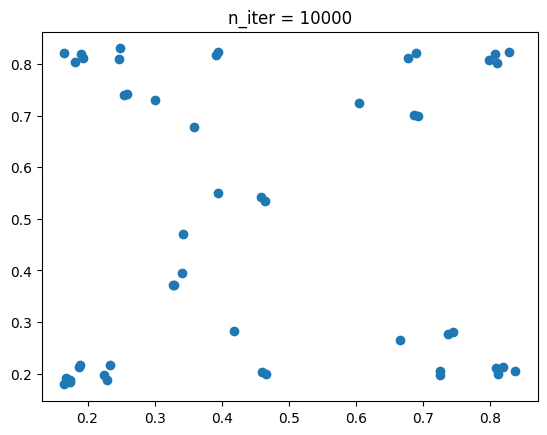

In [27]:
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],)
plt.title("n_iter = 10000")

In [45]:
# Lets try to change the data:/
n_samples = 2000  # Total number of samples
centers = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])  # Centers of the 4 Gaussian distributions
std_dev = 0.1  # Standard deviation of the Gaussian distributions
n_centers = len(centers)
samples_per_center = n_samples // n_centers

data = []
for center in centers:
    samples = np.random.normal(loc=center, scale=std_dev, size=(samples_per_center, 2))
    data.append(samples)

# Combine all samples into a single array
gaussian_data_4_classes = np.vstack(data)

gaussian_data_4_classes_norm = affine_transform(gaussian_data_4_classes, -1, 1)

In [46]:
som_model_simple.train(gaussian_data_4_classes_norm)

Text(0, 0.5, 'y')

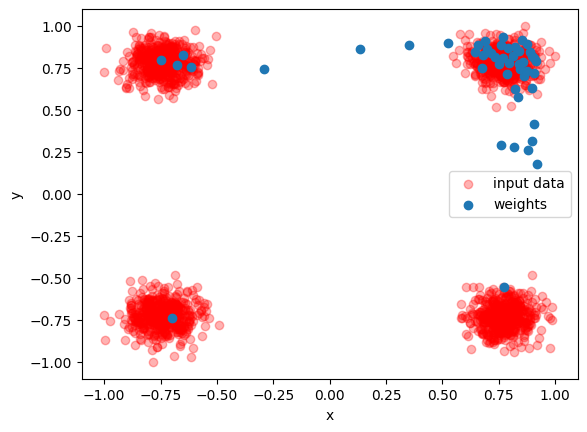

In [47]:
plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

In [17]:
plt.scatter(som_model_simple.weight_cube.reshape(25,2)[:,0],
           som_model_simple.weight_cube.reshape(25,2)[:,1],)
plt.title("n_iter = 100")

ValueError: cannot reshape array of size 98 into shape (25,2)

Text(0.5, 1.0, 'n_iter = 1000')

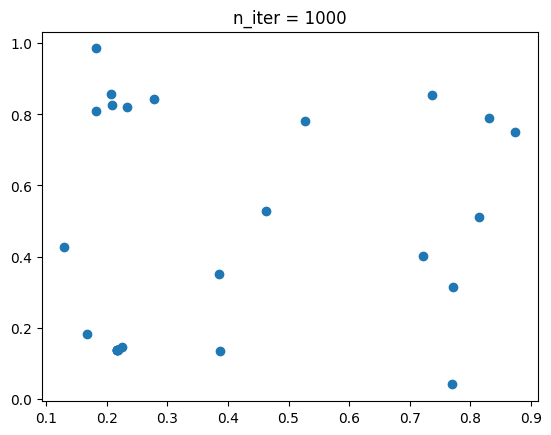

In [105]:
plt.scatter(som_model_simple.weight_cube.reshape(25,2)[:,0],
           som_model_simple.weight_cube.reshape(25,2)[:,1],)
plt.title("n_iter = 1000")

Text(0.5, 1.0, 'n_iter = 1000')

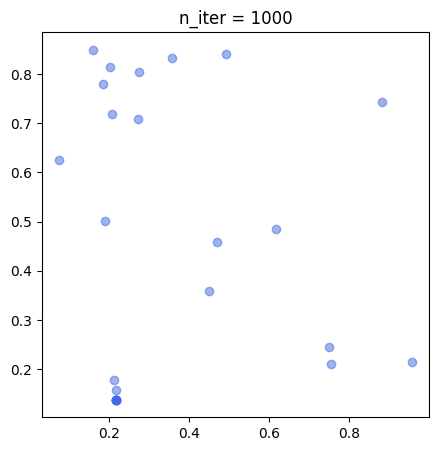

In [63]:
plt.subplots(figsize=(5, 5))

plt.scatter(som_model_simple.weight_cube.reshape(25,2)[:,0],
           som_model_simple.weight_cube.reshape(25,2)[:,1],
           alpha = 0.5, color = 'royalblue')
plt.title("n_iter = 1000")

Text(0.5, 1.0, 'n_iter = 10000')

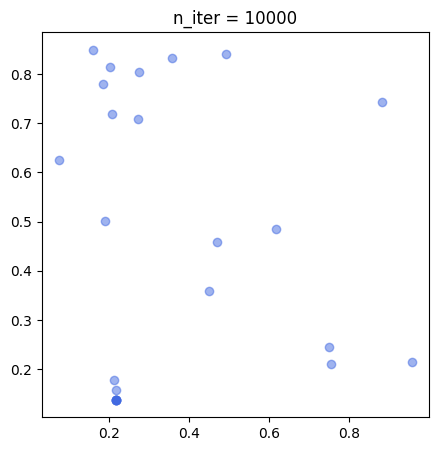

In [64]:
plt.subplots(figsize=(5, 5))

plt.scatter(som_model_simple.weight_cube.reshape(25,2)[:,0],
           som_model_simple.weight_cube.reshape(25,2)[:,1],
           alpha = 0.5, color = 'royalblue')
plt.title("n_iter = 10000")

In [65]:
np.min(gaussian_data_4_classes_norm)

np.float64(0.0)

In [66]:
(som_model_simple.bais_matrix).shape[-1]

5

In [67]:
som_model_simple.weight_cube.reshape(25,2)[:,1]

array([0.50046919, 0.2456628 , 0.13806264, 0.13806264, 0.74380166,
       0.84929979, 0.45823955, 0.13806851, 0.13806592, 0.2097713 ,
       0.81364518, 0.78070496, 0.13837674, 0.13819696, 0.2145616 ,
       0.83355238, 0.80449651, 0.17857315, 0.15874042, 0.62631669,
       0.70787633, 0.84107535, 0.48554356, 0.71791753, 0.35831187])

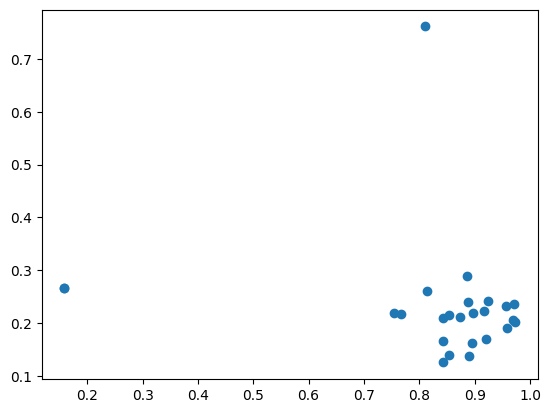

In [26]:
plt.scatter(som_model_simple.weight_cube.reshape(25,2)[:,0],
           som_model_simple.weight_cube.reshape(25,2)[:,1],)

In [17]:
bais_mat_vector = som_model_simple.bais_matrix_history.reshape(7*7,(som_model_simple.bais_matrix_history).shape[-1])

In [28]:
supression_mat_vector = som_model_simple.suppresion_matrix_history.reshape(7*7,(som_model_simple.suppresion_matrix_history).shape[-1])

Text(0, 0.5, 'bais matrix values')

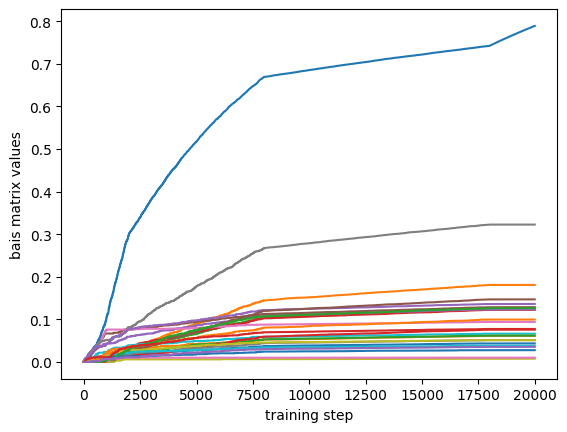

In [38]:
for i in np.arange(25):
    plt.plot(bais_mat_vector[i])
    
#plt.xlim(0,1000)
plt.xlabel("training step")
plt.ylabel("bais matrix values")
#plt.title("currently best working")

Text(0, 0.5, 'bais matrix values')

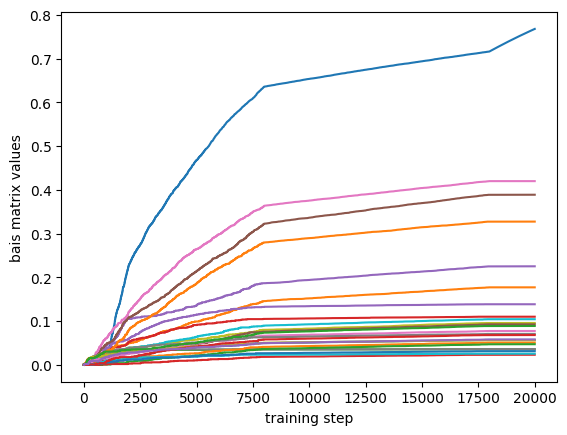

In [19]:
for i in np.arange(25):
    plt.plot(bais_mat_vector[i])
    
#plt.xlim(0,1000)
plt.xlabel("training step")
plt.ylabel("bais matrix values")

Text(0, 0.5, 'bais matrix values')

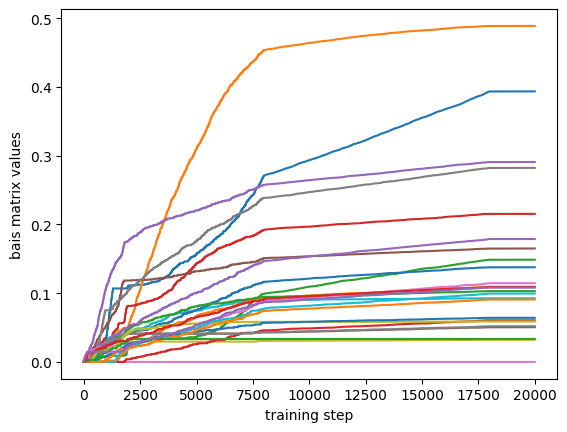

In [26]:
for i in np.arange(25):
    plt.plot(bais_mat_vector[i])
    
#plt.xlim(0,1000)
plt.xlabel("training step")
plt.ylabel("bais matrix values")

In [27]:
supression_mat_vector

array([[ 0.00612245,  0.00612245,  0.00612245, ..., -0.01866573,
        -0.01866573, -0.01866573],
       [ 0.00612245,  0.00612245,  0.00612245, ..., -0.02342915,
        -0.02342915, -0.02342915],
       [ 0.00612245,  0.00612245,  0.00612245, ..., -0.00641656,
        -0.00641656, -0.00641656],
       ...,
       [ 0.00612245,  0.00582245,  0.00582245, ..., -0.0022069 ,
        -0.0022069 , -0.0022069 ],
       [ 0.00612245,  0.00612245,  0.00612245, ..., -0.00149979,
        -0.00149979, -0.00149979],
       [ 0.00612245,  0.00612245,  0.00612245, ..., -0.01139173,
        -0.01139549, -0.01139925]])

Text(0.5, 1.0, 'cumulative suppresion term')

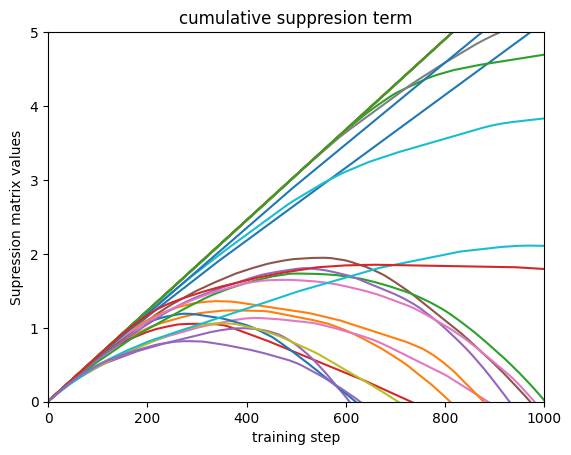

In [27]:
for i in np.arange(25):
    plt.plot(supression_mat_vector[i])
    
plt.xlim(0,1000)
plt.ylim(0,5)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")
plt.title("cumulative suppresion term")

Text(0, 0.5, 'Supression matrix values')

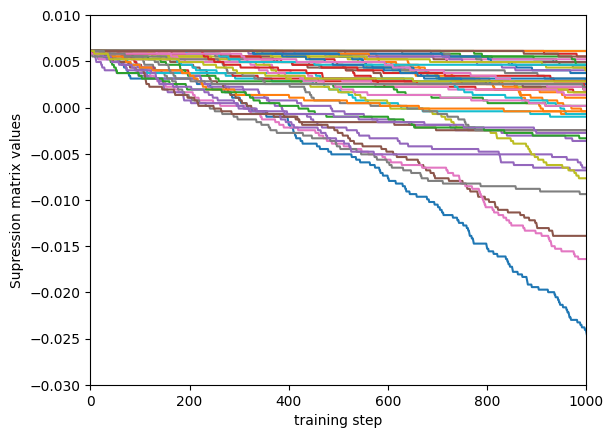

In [36]:
#ax, plt = plt.figure(s)
for i in np.arange(7*7):
    plt.plot(supression_mat_vector[i])
    
plt.xlim(0,1000)
plt.ylim(-0.03,0.01)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")

Text(0, 0.5, 'Supression matrix values')

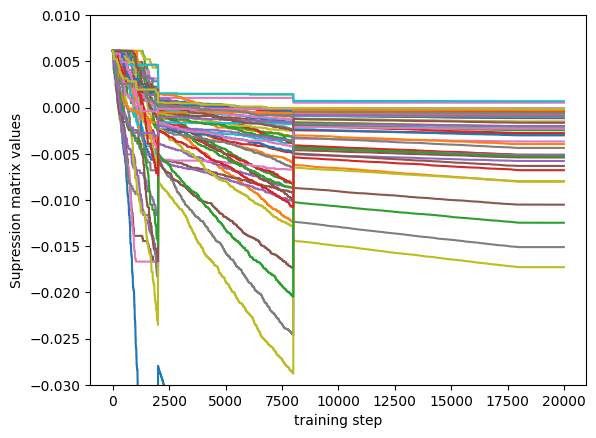

In [48]:
for i in np.arange(7*7):
    plt.plot(supression_mat_vector[i])
    
#plt.xlim(0,1000)
plt.ylim(-0.03,0.01)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")

Text(0, 0.5, 'Supression matrix values')

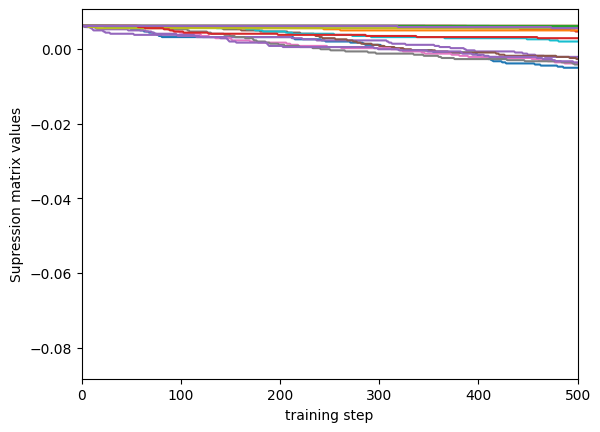

In [20]:
for i in np.arange(25):
    plt.plot(supression_mat_vector[i])
    
plt.xlim(0,500)
#plt.ylim(0,0.015)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")

Text(0, 0.5, 'Supression matrix values')

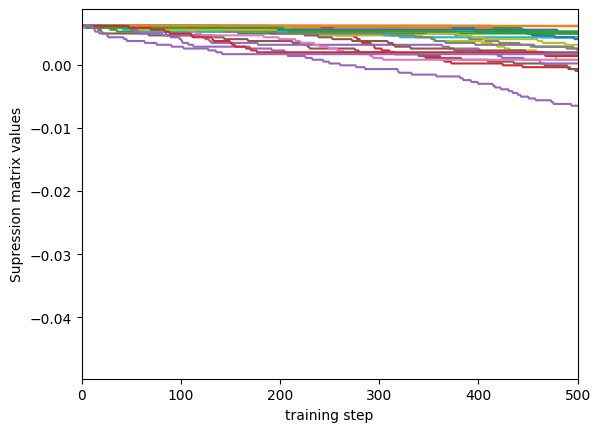

In [28]:
for i in np.arange(25):
    plt.plot(supression_mat_vector[i])
    
plt.xlim(0,500)
#plt.ylim(0,0.015)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")

Text(0, 0.5, 'Supression matrix values')

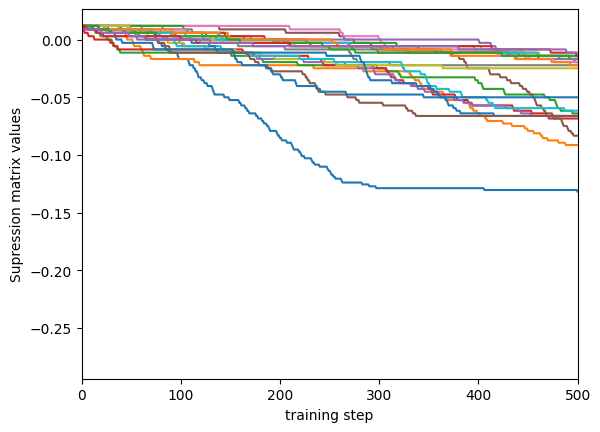

In [25]:
for i in np.arange(25):
    plt.plot(supression_mat_vector[i])
    
plt.xlim(0,500)
#plt.ylim(0,0.015)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")

Text(0, 0.5, 'Supression matrix values')

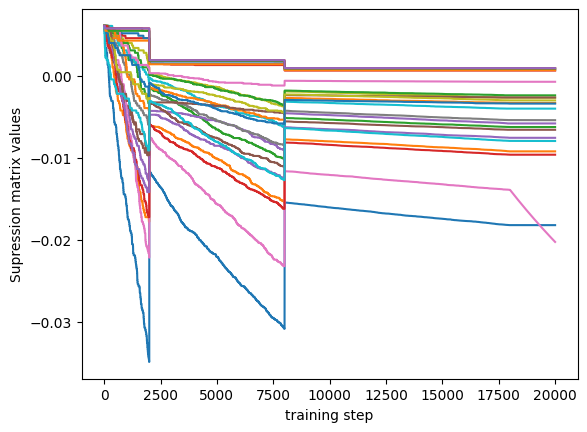

In [30]:
for i in np.arange(25):
    plt.plot(supression_mat_vector[i])
    
#plt.xlim(0,2000)
#plt.ylim(0,0.015)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")

In [37]:
from sciSOM import calculate_u_matrix, calculate_density_matrix, display_density_matrix

In [38]:
gaussian_data_4_classes_wcube = som_model_simple.weight_cube

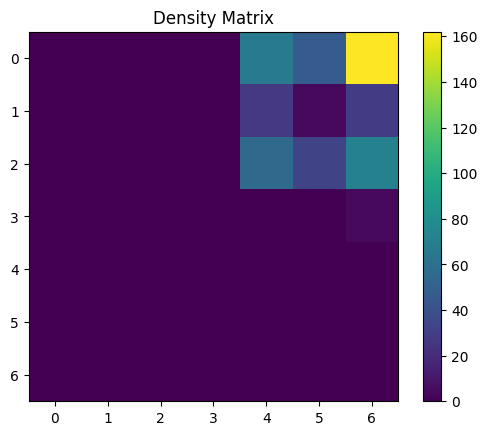

In [39]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[1500:])
display_density_matrix(DENS_MAT)

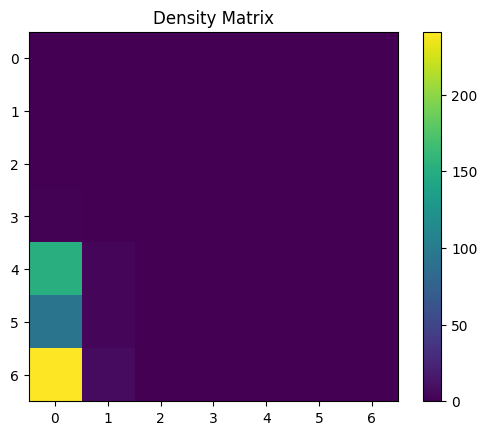

In [40]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[1000:1500])
display_density_matrix(DENS_MAT)

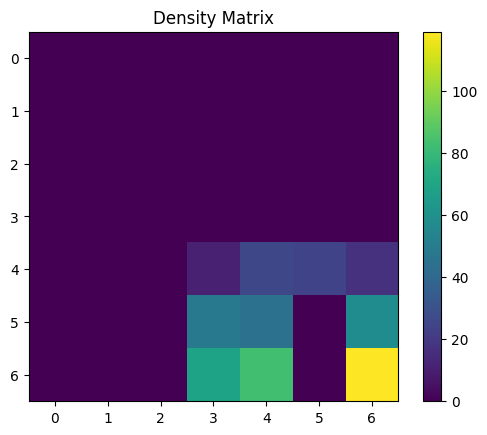

In [41]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[500:1000])
display_density_matrix(DENS_MAT)

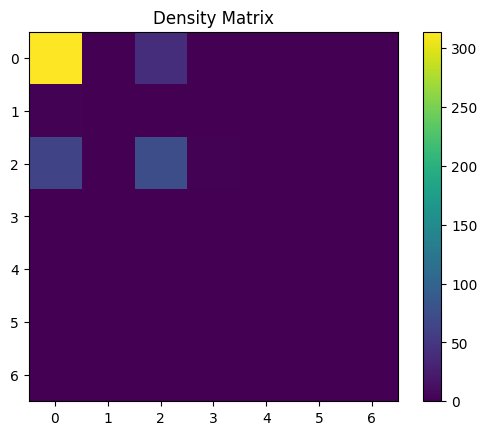

In [42]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[:500])
display_density_matrix(DENS_MAT)

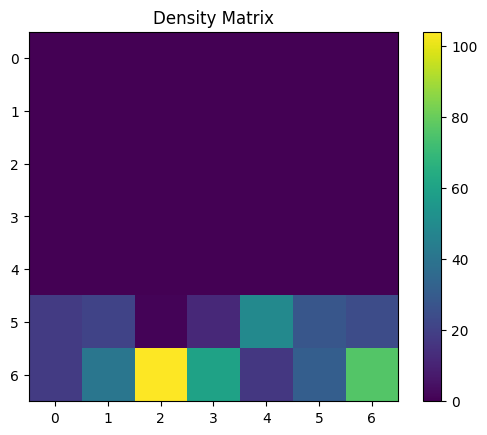

In [38]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[:500])
display_density_matrix(DENS_MAT)

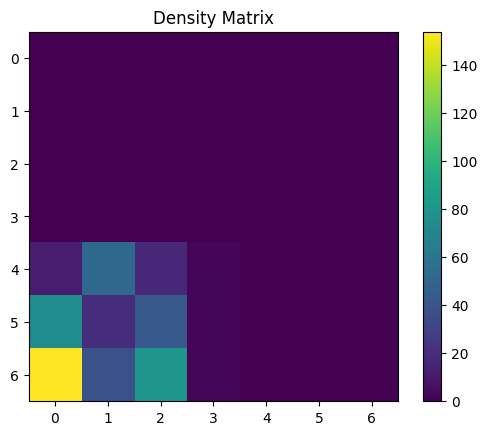

In [34]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[500:1000])
display_density_matrix(DENS_MAT)

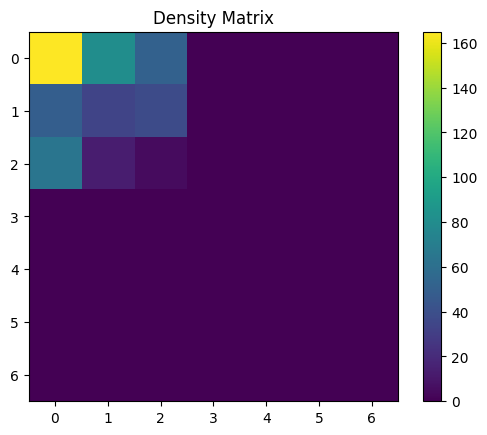

In [35]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[1000:1500])
display_density_matrix(DENS_MAT)

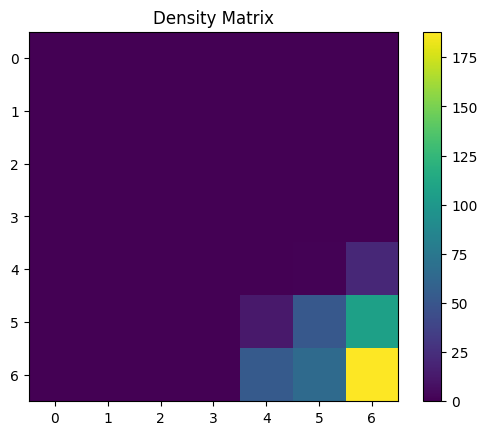

In [36]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[1500:])
display_density_matrix(DENS_MAT)

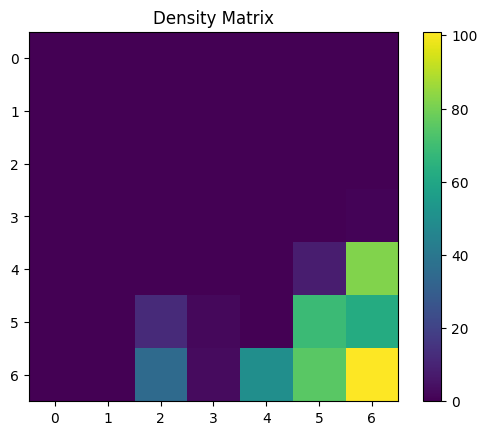

In [76]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[:500])
display_density_matrix(DENS_MAT)

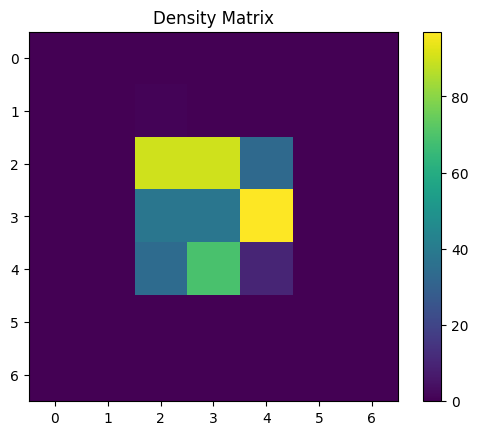

In [77]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[500:1000])
display_density_matrix(DENS_MAT)

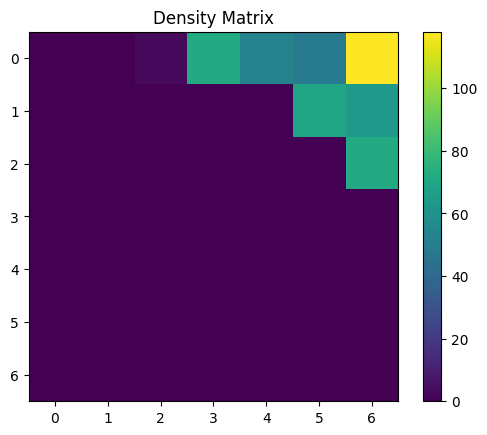

In [78]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[1000:1500])
display_density_matrix(DENS_MAT)

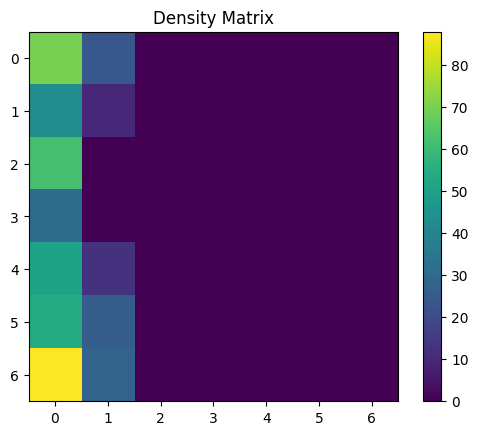

In [79]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[1500:])
display_density_matrix(DENS_MAT)

In [10]:
som_model_simple.weight_cube.reshape(-1, som_model_simple.weight_cube.shape[-1])

array([[0.52252776, 0.09188167],
       [0.29709486, 0.36326271],
       [0.36354551, 0.19518023],
       [0.80537997, 0.90949245],
       [0.09050786, 0.99652523],
       [0.05403491, 0.71701745],
       [0.06837312, 0.67419464],
       [0.42750227, 0.49652058],
       [0.8009388 , 0.68172682],
       [0.73486492, 0.33279753],
       [0.32226838, 0.78123722],
       [0.50686476, 0.5048668 ],
       [0.19582163, 0.9977195 ],
       [0.50555956, 0.03899522],
       [0.77185473, 0.04193766],
       [0.71524954, 0.17287507],
       [0.06808256, 0.2089964 ],
       [0.58475083, 0.47103631],
       [0.04948757, 0.20916526],
       [0.51106283, 0.5214096 ],
       [0.07654304, 0.26911575],
       [0.51279194, 0.56024076],
       [0.56096732, 0.47997732],
       [0.98713948, 0.34866745],
       [0.32900034, 0.74555621]])

In [10]:
test = np.zeros((5,5))

In [12]:
test.reshape(-1, test.shape[-1])

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [43]:
def convert_to_float(arr):
    # Flatten the array to handle nested objects if any
    flat_arr = arr.ravel()
    
    # Convert all elements to float
    flat_arr = [float(element) for element in flat_arr]
    
    # Reshape back to the original shape
    return np.array(flat_arr).reshape(arr.shape)

In [44]:
penguins_df = pd.read_csv("../test_data/penguins.csv")
penguins_df = penguins_df.dropna()

input_data= np.array((penguins_df.to_numpy()[:,2],
                    penguins_df.to_numpy()[:,3],
                    penguins_df.to_numpy()[:,4],
                    penguins_df.to_numpy()[:,5]))

input_data = convert_to_float(input_data)
input_data = np.transpose(input_data)

In [45]:
data_normalized = affine_transform(input_data, 0, 1)

In [46]:
parameters_schedule = np.zeros(3, dtype=dtype)
parameters_schedule[0] = (2000, 0.7, 0.2, 3)
parameters_schedule[1] = (8000, 0.01, 0.1, 2)
parameters_schedule[2] = (40000, 0.001, 0.1, 1)

In [47]:
parameters_schedule = np.zeros(4, dtype=dtype)
parameters_schedule[0] = (2000, 0.3, 0.001, 0.3)
parameters_schedule[1] = (8000, 0.01, 0.0005, 0.1)
parameters_schedule[2] = (20000, 0.001, 0.0001, 0.05)
parameters_schedule[3] = (100000, 0.0001, 0.00005, 0.01)

In [48]:
som_model_simple = SOM(x_dim = 7, y_dim = 7, input_dim = 4, n_iter=40000,
                   learning_parameters=parameters_schedule, som_type = "cSOM",
                       neighborhood_decay = 'exponential',
                   decay_type='schedule', mode = "online", #neighborhood_decay = "exponential"
                       save_weight_cube_history = True
                   )

In [49]:
som_model_simple.train(data_normalized)

In [50]:
wcube = som_model_simple.weight_cube

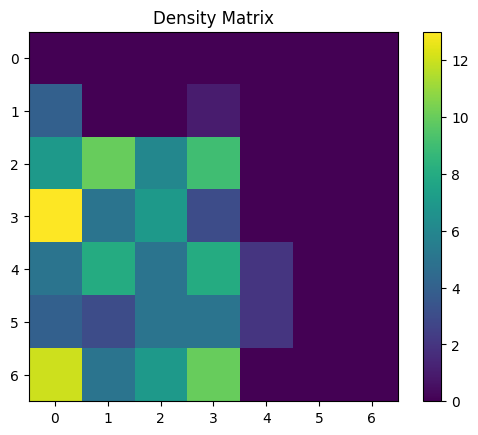

In [51]:
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, data_normalized[:146])
display_density_matrix(DENS_MAT)

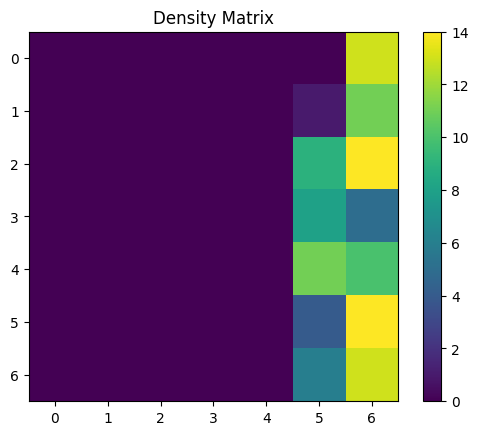

In [52]:
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, data_normalized[146:146+119])
display_density_matrix(DENS_MAT)

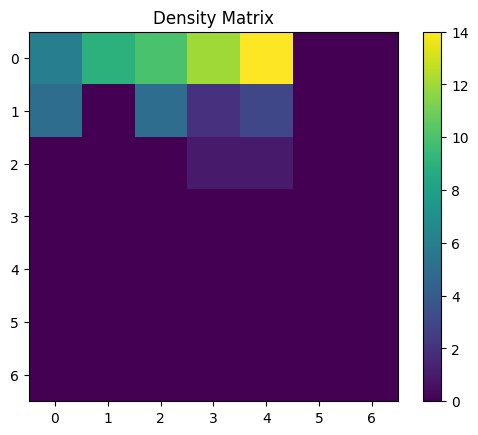

In [53]:
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, data_normalized[146+119:])
display_density_matrix(DENS_MAT)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from typing import Union

def plot_SOM_gird_neurons(weight_cube):
    """
    This function take in a nunr file from NeuroScope and converts it into a useful format to us
    Then it uses the data in the nunr file to identify which data samples belong to each PE
    Finally it takes this data and plots it such that we can overlay any data we want.

    input_data:      waveforms (peaks, peaklets)
    grid_x_dim:      SOM x-dimension [list of x dim per sample]
    grid_y_dim:      SOM y-dimension [same as above]
    x_dim_data_cube: x-dimension of the input data cube for the SOM
    output_img:      name of file to save the image to
    is_struct_array: does the data need to be accessed as peaks['data']?
    """
    
    xgrid, ygrid, data_dim = np.shape(weight_cube)
    
    # Plotting section
    fig, ax = plt.subplots(nrows=ygrid, ncols=xgrid, figsize=(5, 5))

    a = 1
    for i in np.arange(ygrid):
        for j in np.arange(xgrid):
            ax[j,i].plot(weight_cube[j,i,:])
            ax[i,j].axis('off')
            ax[i,j].set_xlim(0, data_dim)
            ax[i,j].set_ylim(0, 1)

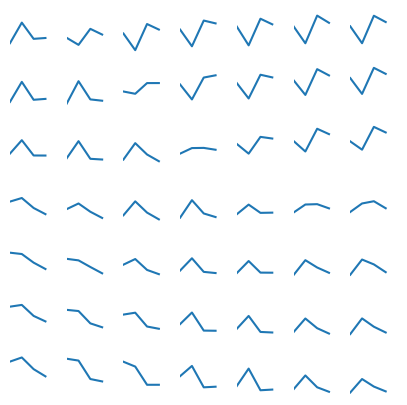

In [66]:
plot_SOM_gird_neurons(wcube)

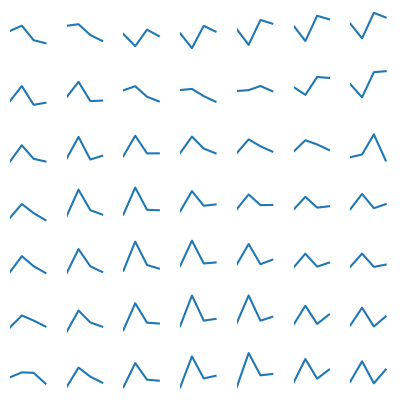

In [51]:
plot_SOM_gird_neurons(wcube)

In [52]:
bais_mat_vector = som_model_simple.bais_matrix_history.reshape(7*7,(som_model_simple.bais_matrix_history).shape[-1])

Text(0, 0.5, 'bais matrix values')

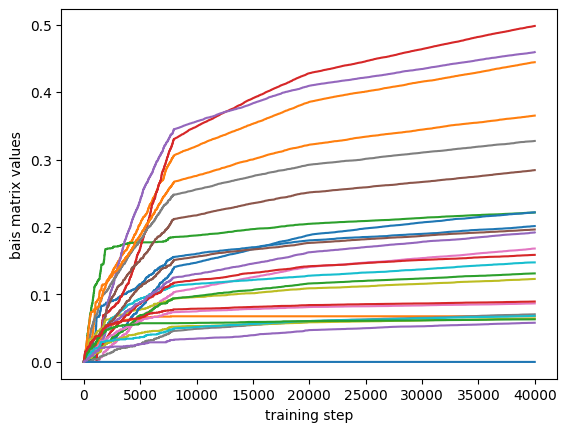

In [53]:
for i in np.arange(25):
    plt.plot(bais_mat_vector[i])
    
#plt.xlim(0,1000)
plt.xlabel("training step")
plt.ylabel("bais matrix values")